# Identify Reciter

# 2_Data_Preparation
This notebook prepares the data for training in the following steps:
- Quick look at the downloaded data & select 5 reciters from the downloaded data
- Select the Sura/Aya for the reciter
- Mark the data for training/validation/test such that the same Sura/Aya are used for these
- Select the feature(s) to be extracted
- Extract the feature(s)
- Save the train/val/test data

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

Strategies for Effective Data Visualization
https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

Subsampling a training set to match a test set - Part 1
https://maxhalford.github.io/blog/subsampling-1/

Let's take care of package imports and variable defnitions & Helper functions before looking at the downloaded data.

In [ ]:
# %load helpers.py
# Cut-paste above line without "#" in cell below & execute once to get code in the cell, 
# and then execute again to load the functions

In [2]:
# %load helpers.py
##################
# imports
import os
import csv
import re
import pathlib
import xml.etree.ElementTree as ET
import zipfile
import shutil
import librosa
import math
import numpy as np 
import pandas as pd 
import warnings
import audioread
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
from pydub.utils import mediainfo

# https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
# https://levelup.gitconnected.com/audio-data-analysis-using-deep-learning-part-1-7f6e08803f60
# https://www.eurasip.org/Proceedings/Eusipco/Eusipco2018/papers/1570434062.pdf

##################
# Constants
debug          = False
zip_data_dir   = '../../L5_Capstone/Audio/Quran'
zip_file_name  = '000_versebyverse.zip'
data_dir       = 'data'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")
quran_meta_xml = os.path.join(os.getcwd(), data_dir, "quran-data.xml")
SuraIndexMIN   = 1
SuraIndexMAX   = 114
AyaIndexMIN    = 0
AyaIndexMAX    = 6236

# Suppress this warning from librosa:
# UserWarning: PySoundFile failed. Trying audioread instead.
warnings.filterwarnings('ignore')

if debug:
    print("quran_meta_xml :", quran_meta_xml)


##################
# Functions
def hello_world():
    print("Hello world from helpers.py!")

def qsura_ayat_to_labels(suraFrom=None, suraTo=None, ayaFrom=None, ayaTo=None):
    """ Converts either Sura or Aya numbers to labels.

       :param suraFrom: An interger for Sura index to start from. Valid numbers are 1 to 114 (default: None)
       :type suraFrom: int
       :param suraTo: An interger for Sura index to end to. Valid numbers are 1 to 114 (inclusive) (default: None)
       :type suraTo: int
       :param ayaFrom: An interger for Aya index to start from (default: None)
       :type ayaFrom: int
       :param ayaTo: An interger for Aya index to end to (inclusive) (default: None)
       :type ayaTo: int
       :return: A list of labels in the form ['001001', '001002', ...], A list of aya number in quran [0, 2, ... AyaIndexMAX]
       :rtype: list, list 

    """

    # Return lists
    labels_list = list()
    ayainq = list()

    useSura = False
    useAya = False
    if suraFrom is not None and suraTo is not None:
        if suraFrom < SuraIndexMIN or suraFrom > SuraIndexMAX:
            print("ERROR: {} not between {} and {}".format('suraFrom', SuraIndexMIN,SuraIndexMAX))
            return labels_list, ayainq
        if suraTo < SuraIndexMIN or suraTo > SuraIndexMAX:
            print("ERROR: {} not between {} and {}".format('suraTo', SuraIndexMIN,SuraIndexMAX))
            return labels_list, ayainq
        useSura = True
    elif ayaFrom is not None and ayaTo is not None:
        if ayaFrom < AyaIndexMIN or ayaFrom > AyaIndexMAX:
            print("ERROR: {} not between {} and {}".format('ayaFrom', AyaIndexMIN,AyaIndexMAX))
            return labels_list, ayainq
        if ayaTo < AyaIndexMIN or ayaTo > AyaIndexMAX:
            print("ERROR: {} not between {} and {}".format('ayaTo', AyaIndexMIN,AyaIndexMAX))
            return labels_list, ayainq
        useAya = True

    ##################
    # qmeta: Quran Meta Data
    qmeta_tree = ET.parse(quran_meta_xml)
    qmeta_root = qmeta_tree.getroot()
    #print("qmeta_root :", qmeta_root)

    # As an Element, root has a tag and a dictionary of attributes:
    qmeta_root_tag = qmeta_root.tag
    qmeta_root_att = qmeta_root.attrib
    #print("qmeta_root_tag = " + qmeta_root_tag)
    #print("qmeta_root_att = ")
    #print(qmeta_root_att)

    # It also has children nodes over which we can iterate:
    for qmeta_suras in qmeta_root:
        qmeta_suras_tag = qmeta_suras.tag
        #qmeta_suras_att = qmeta_suras.attrib
        #print("qmeta_suras_tag = " + qmeta_suras_tag)
        #print("qmeta_suras_att = ")
        #print(qmeta_suras_att)
        if qmeta_suras_tag == "suras":
            for qmeta_sura in qmeta_suras:
                qmeta_sura_tag = qmeta_sura.tag
                #qmeta_sura_att = qmeta_sura.attrib
                #print("qmeta_sura_tag = " + qmeta_sura_tag)
                #print("qmeta_sura_att = ")
                #print(qmeta_sura_att)
                if qmeta_sura_tag == "sura":
                    #print("qmeta_sura :", qmeta_sura)
                    qmeta_sura_index = qmeta_sura.attrib.get('index')
                    qmeta_sura_ayas = qmeta_sura.attrib.get('ayas')
                    qmeta_sura_start = qmeta_sura.attrib.get('start')
                    #print("qmeta_sura_index :", qmeta_sura_index)
                    #print("qmeta_sura_ayas :", qmeta_sura_ayas)
                    #print("qmeta_sura_start :", qmeta_sura_start)

                    if useSura:
                        if int(qmeta_sura_index) >= suraFrom and int(qmeta_sura_index) <= suraTo:
                            #print("  MKC: qmeta_sura_index :", qmeta_sura_index)
                            #print("  MKC: qmeta_sura_ayas :", qmeta_sura_ayas)
                            #print("  MKC: qmeta_sura_start :", qmeta_sura_start)
                            for i in range(1, int(qmeta_sura_ayas)+1):
                                labels_list.append("{:03d}{:03d}".format(int(qmeta_sura_index), i))

                    if useAya:
                        # Get the current sura end ayat
                        sura_start = int(qmeta_sura_start)
                        sura_end = sura_start + (int(qmeta_sura_ayas) - 1)
                        #print("sura start -> end: {} -> {}".format(sura_start, sura_end))
                        for i in range(sura_start, sura_end+1):
                            if i >= ayaFrom and i <= ayaTo:
                                #print("  -> ",i)
                                ayainq.append(i)
                                labels_list.append("{:03d}{:03d}".format(int(qmeta_sura_index), i+1-sura_start))

    #print("labels_list :", labels_list)
    return labels_list, ayainq

"""
# abc
labels_list, ayainq_list = qsura_ayat_to_labels(suraFrom=113, suraTo=114, ayaFrom=None, ayaTo=None)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(suraFrom=113, suraTo=115, ayaFrom=None, ayaTo=None)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()

labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=6)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=1, ayaTo=6)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=1, ayaTo=7)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=7)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=0)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=1)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=290, ayaTo=292)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=6228, ayaTo=6236)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=6228, ayaTo=6237)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=-1, ayaTo=6236)
print("expected_labels_list =", labels_list)
print("ayainq_list =", ayainq_list)
print()
# Create a dictonary of lookup between labels and aya number in Quran
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=6236)
lbl_aya_df = pd.DataFrame(list(zip(labels_list, ayainq_list)), 
               columns=['Label', 'AyaInQuran']) 

lbl_aya_dict = dict(zip(labels_list, ayainq_list))

print()
#print("labels_list :", labels_list)
# abc
"""
# abc

def report_stats_zip_data(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name):
    """ Reports statitics for the zipped data

       :param zip_data_dir: Directory containing the zipped data
       :type zip_data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :return: A list of directory names in zip_data_dir
       :rtype: list 

    """

    # Return list
    dir_names = list()

    # Directory names are also names of the reciters
    print("{:30s} {:10s} {:8s} {:9s}".format("Reciter name", "Data Size", "Files", "MP3 Files"))
    print("{:30s} {:10s} {:8s} {:9s}".format("============", "=========", "=====", "========="))
    for dd in os.listdir(zip_data_dir):
        # Each directory has one zip file called 000_versebyverse.zip
        dd_zip_file = zip_data_dir + "/" + dd + "/" + zip_file_name
        # Size
        dd_size_bytes = os.path.getsize(dd_zip_file)
        dd_size_MB = dd_size_bytes / (1024 * 1024)
        # Number of files
        archive = zipfile.ZipFile(dd_zip_file, 'r')
        num_files = len(archive.namelist())
        # Mp3 files
        mp3_cnt = 0
        for ff in archive.namelist():
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} MB {:6d} {:12d}".format(dd, dd_size_MB, num_files, mp3_cnt))
        dir_names.append(dd)
    return dir_names

# Directory size (https://stackoverflow.com/questions/1392413/calculating-a-directorys-size-using-python)
def get_dir_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

def report_stats_audio_data(data_dir=audio_data_dir):
    """ Reports statitics for the audio data

       :param data_dir: Directory containing the audio data
       :type data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :return: DataFrame with audio directory details
       :rtype: DataFrame 

    """

    column_names = list()
    column_names.append('ReciterName')
    column_names.append('FileName')
    column_names.append('DataSizeKB')
    column_names.append('BitRate')
    column_names.append('Channels')
    column_names.append('Mono/Stereo')
    column_names.append('Duration')
    column_names.append('FileNoExt')
    column_names.append('Sura')
    column_names.append('Aya')
    column_names.append('AyaInQuran')

    sv_reciter   = list()
    sv_file_name = list()
    sv_data_size = list()
    sv_bit_rate  = list()
    sv_ch        = list()
    sv_ms        = list()
    sv_dur       = list()
    sv_filenoext = list()
    sv_sura      = list()
    sv_aya       = list()
    sv_ayainq    = list()

    # Directory names are also names of the reciters
    print("{:30s} {:10s} {:4s} {:4s} {:2s} {:6s} {:9s}".format("Reciter name/MP3 File", "Data Size", "MP3s", "kbps", "Ch", "Mono/S", "Duration(sec)"))
    print("{:30s} {:10s} {:4s} {:4s} {:2s} {:6s} {:9s}".format("==============================", "=========", "====", "====", "==", "======", "============="))
    for dd in os.listdir(data_dir):
        reciter_dir = os.path.join(data_dir, dd)
        # Size
        #dd_size_bytes = os.path.getsize(reciter_dir)
        dd_size_bytes = get_dir_size(reciter_dir)
        dd_size_KB = dd_size_bytes / (1024)
        # Number of files
        num_files = len(os.listdir(reciter_dir))
        # Mp3 files
        mp3_cnt = 0
        for ff in os.listdir(reciter_dir):
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} KB {:5d}".format(dd, dd_size_KB, mp3_cnt))

        for ff in os.listdir(reciter_dir):
            if not ff.endswith('.mp3'):
                continue
            mp3_file = os.path.join(reciter_dir, ff)

            duration = channel_layout = bit_rate = channels = bit_rate_kbps = -1
            try:
                # Look at some audio features
                y, sr = librosa.load(mp3_file, sr=None)
                # Get the length of the audio
                duration = librosa.core.get_duration(y=y, sr=sr)
                duration = len(y) / sr

                # Sample rate
                info = mediainfo(mp3_file)
                #print(info)
                channel_layout = info['channel_layout']
                bit_rate = int(info['bit_rate'])
                channels = int(info['channels'])
                #artist = info['artist']
                artist = ""
                bit_rate_kbps = bit_rate / 1000
            
            except:
                print("Couldn't process, skipping: ", mp3_file)

            #print("{:>30s} {:6.0f} KB {:5d} {:12d} {:5.1f}".format(ff, dd_size_KB, 0, int(info['sample_rate']), duration))
            #with audioread.audio_open(mp3_file) as input_file:
            #    sr_native = input_file.samplerate
            #    n_channels = input_file.channels
            #print(sr_native, n_channels)
            #print("{:>30s} {:6.0f} KB {:5s} {:4.0f} {:2d} {:6s} {:13.1f}".format(ff, dd_size_KB, "", bit_rate_kbps, channels, channel_layout, duration))

            # Size
            dd_size_bytes = os.path.getsize(mp3_file)
            dd_size_KB = dd_size_bytes / (1024)

            sv_reciter.append(dd)
            sv_file_name.append(ff)
            sv_data_size.append(int(dd_size_KB))
            sv_bit_rate.append(int(bit_rate_kbps))
            sv_ch.append(channels)
            sv_ms.append(channel_layout)
            sv_dur.append(duration)
            filenoext, sura, aya, ayainq = get_mp3_file_info(ff)
            sv_filenoext.append(filenoext)
            sv_sura.append(sura)
            sv_aya.append(aya)
            sv_ayainq.append(ayainq)
            #break
        #break
    
    # Create a DataFrame with all the info
    df = pd.DataFrame(list(zip(sv_reciter, sv_file_name, sv_data_size, 
        sv_bit_rate, sv_ch, sv_ms, sv_dur, sv_filenoext, sv_sura, sv_aya, sv_ayainq)), 
               columns=column_names) 

    return df

lbl_aya_dict = dict()
def get_mp3_file_info(file_name):
    """ Get info from MP3 file name

       :param file_name: MP3 file name
       :type file_name: str
       :return: label, sura, aya, ayainquran
       :rtype: str 

    File name should be ######.mp3, e.g. 001004.mp3
        SuraAya    = 001004
        Sura       = 1
        Aya        = 4
        AyaInQuran = 3
    """

    # Return items
    suraaya   = ''
    sura      = -1
    aya       = -1
    ayainquan = -1

    suraaya = os.path.splitext(file_name)[0]
    sura = int(suraaya[:3])
    aya  = int(suraaya[3:])
    ayainquan = int(lbl_aya_dict[suraaya])

    return suraaya, sura, aya, ayainquan

def audio_data_initialize(dir_name=audio_data_dir):
    """ Initialize audio data directory

       :param dir_name: Directory name to initialize
       :type dir_name: str
       :return: dir_name
       :rtype: str 

    """

    # If directory exists, delete the directory 
    if pathlib.Path(dir_name).exists():
        print("Directory exists, deleting :", dir_name)
        #pathlib.Path(dir_name).rmdir()
        shutil.rmtree(dir_name)

    # Create the directory
    print("Creating directory :", dir_name)
    pathlib.Path(dir_name).mkdir()

    return dir_name

def populate_audio_files(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name, 
        audio_data_dir=audio_data_dir, reciters=None, suraFrom=None, suraTo=None,
        ayaFrom=None, ayaTo=None, checkOnly=False):
    """ Populate audio files for the reciters in the given directory

       :param zip_data_dir: Directory containing the zipped data
       :type zip_data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :return: None
       :rtype: None

    """

    audio_labels, ayainq_list = qsura_ayat_to_labels(suraFrom=suraFrom, suraTo=suraTo, 
        ayaFrom=ayaFrom, ayaTo=ayaTo)
    #print("Audio labels: ", audio_labels)
    #print("Aya in Quran labels: ", ayainq_list)

    for dd in os.listdir(zip_data_dir):
        if dd not in reciters:
            continue

        print("Found reciter: ", dd)
        # Create the directory
        reciter_dir = os.path.join(audio_data_dir, dd)
        print("Creating directory :", reciter_dir)
        pathlib.Path(reciter_dir).mkdir()

        # Each directory has one zip file called 000_versebyverse.zip
        dd_zip_file = zip_data_dir + "/" + dd + "/" + zip_file_name
        # Size
        dd_size_bytes = os.path.getsize(dd_zip_file)
        dd_size_MB = dd_size_bytes / (1024 * 1024)
        # Number of files
        archive = zipfile.ZipFile(dd_zip_file, 'r')
        num_files = len(archive.namelist())
        # Mp3 files
        mp3_cnt = 0
        for ff in archive.namelist():
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} MB {:6d} {:12d}".format(dd, dd_size_MB, num_files, mp3_cnt))

        num_files_extracted = 0
        for lbl in audio_labels:
            mp3_file = lbl + ".mp3"
            if mp3_file not in archive.namelist():
                print("ERROR: Couldn't find file: ", mp3_file)
                continue
            archive.extract(mp3_file, path=reciter_dir)
            num_files_extracted += 1
        print("{} files extracted".format(num_files_extracted))
    print()

    return None

# abc
"""
reciter_names = report_stats_zip_data(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name)
print("Reciter name list :", reciter_names)
"""
# abc

"""
selected_reciters = ['AbdulBasit', 'AbdullahBasfar']
"""
# abc
"""
selected_reciters = ['AbdulBasit', 'AbdullahBasfar', 'AbdulSamad', 'AbdurrahmaanAs-Sudais', 'AbuBakrAsh-Shaatree', 'Ajami', 'Alafasy', 'AliJaber', 'FaresAbbad', 'Ghamadi', 'HaniRifai', 'Karim Mansoori-Iran', 'KhalefaAl-Tunaiji', 'MaherAlMuaiqly', 'MinshawyMujawwad', 'MohammadalTablaway', 'MuhammadAyyoub', 'MuhammadJibreel', 'Parhizgar', 'SaoodbinIbraaheemAsh-Shuraym', 'Sudais']
audio_data_initialize(dir_name=audio_data_dir)

suraFrom = None
suraTo = None
ayaFrom = 0
ayaTo = 1
populate_audio_files(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name, 
        audio_data_dir=audio_data_dir, reciters=selected_reciters, suraFrom=suraFrom, suraTo=suraTo,
        ayaFrom=ayaFrom, ayaTo=ayaTo, checkOnly=True)

df = report_stats_audio_data(data_dir=audio_data_dir)

print(df)
"""

def extract_audio_features(self, list_of_audiofiles):

    data = np.zeros(
        (len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64
    )
    target = []

    for i, file in enumerate(list_of_audiofiles):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
        )
        spectral_center = librosa.feature.spectral_centroid(
            y=y, sr=sr, hop_length=self.hop_length
        )
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(
            y=y, sr=sr, hop_length=self.hop_length
        )

        splits = re.split("[ .]", file)
        genre = re.split("[ /]", splits[1])[3]
        target.append(genre)

        data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
        data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
        data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
        data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

        print(
            "Extracted features audio track %i of %i."
            % (i + 1, len(list_of_audiofiles))
        )

    return data, np.expand_dims(np.asarray(target), axis=1)

def extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512,
    pad_duration=None, read_duration=None, features_list=['mfcc', 'zcr', 'spectral_center', 
    'spectral_rolloff', 'chroma', 'spectral_bandwidth_2', 'spectral_bandwidth_3', 
    'spectral_bandwidth_4', 'spectral_contrast'], shp_0=None, shp_1=None):

    file_name = os.path.join(audio_data_dir, reciter, mp3_file)

    columns = data = feature_shapes = new_shp_0 = new_shp_1 = None

    try:
        y , sr = librosa.load(file_name, sr=sr, duration=read_duration)
        orig_duration = len(y) / sr
        #print("pad_duration = ", pad_duration)
        #print("read_duration = ", read_duration)
        #print("orig_duration = ", orig_duration)
        # Pad the duration
        if pad_duration is not None:
            if pad_duration > orig_duration:
                new_len_y = pad_duration * sr
                y = librosa.util.fix_length(y, new_len_y)
            elif pad_duration <= orig_duration:
                # Nothing to be done!
                pass
        duration = len(y) / sr
        #print("FINAL: duration = ", duration)

        # Column names
        columns = list()

        # Feature shapes
        feature_shapes = list()

        #print("shp_0 :", shp_0)
        #print("shp_1 :", shp_1)
        if shp_0 is not None and shp_1 is not None:
            if 'spect' in features_list:
                #data = np.empty(
                #    (shp_0, shp_1), dtype=np.float64
                #)
                data = np.empty(
                    (shp_1, shp_0), dtype=np.float64
                )
            else:
                data = np.zeros(
                    (shp_1, shp_0), dtype=np.float64
                )
            #data = np.empty(
            #  (0, shp_0, shp_1)
            #)
            #print("data initialized:")
            #print(type(data))
            #print(data.shape)
        else:
            data = list()
            #print(type(data))

        # Start index is 0 and gets updated after feature is concatenated to "data"
        start_idx = 0
        if 'mfcc' in features_list:
            #spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft
            )
            feature_shapes.append(mfcc.shape)
            #print("mfcc:")
            #print(mfcc.shape)
            #print("mfcc.T:")
            #print(mfcc.T)
            #print("mfcc:")
            #print(mfcc)
            #print(np.amin(mfcc), np.amax(mfcc), np.mean(mfcc))
            divby = abs(np.amin(mfcc))
            if abs(np.amax(mfcc)) > divby:
                divby = abs(np.amax(mfcc))

            #print("divby = ", divby)
            mfcc_orig = mfcc
            x = mfcc / divby
            #print("x = ", x)
            #x = mfcc / math.abs()
            mfcc = x
            for i in range(1, mfcc.shape[0]+1):
                columns.append('mfcc{}'.format(i))
            if shp_0 is not None:
                #data = np.append(data, [mfcc.T], axis=0)
                data[:, start_idx:start_idx+mfcc.shape[0]] = mfcc.T[0:mfcc.shape[1], :]
                start_idx += mfcc.shape[0]
                #print("mfcc start_idx updated to: ", start_idx)
        if 'zcr' in features_list:
            zcr = librosa.feature.zero_crossing_rate(y)
            feature_shapes.append(zcr.shape)
            #print("zcr:")
            #print(zcr.shape)
            #print(zcr.T)
            #print(zcr.shape[1])
            columns.append('zcr')
            if shp_0 is not None:
                data[:, start_idx:start_idx+zcr.shape[0]] = zcr.T[0:zcr.shape[1], :]
                start_idx += zcr.shape[0]
                #print("zcr start_idx updated to: ", start_idx)
        if 'spectral_center' in features_list:
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=hop_length
            )
            feature_shapes.append(spectral_center.shape)
            #print("spectral_center:")
            #print(spectral_center.shape)
            columns.append('spectral_center')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_center.shape[0]] = spectral_center.T[0:spectral_center.shape[1], :]
                start_idx += spectral_center.shape[0]
                #print("spectral_center start_idx updated to: ", start_idx)
        if 'spectral_rolloff' in features_list:
            #spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)
            feature_shapes.append(spectral_rolloff.shape)
            #print("spectral_rolloff:")
            #print(spectral_rolloff.shape)
            #print(spectral_rolloff)
            columns.append('spectral_rolloff')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_rolloff.shape[0]] = spectral_rolloff.T[0:spectral_rolloff.shape[1], :]
                start_idx += spectral_rolloff.shape[0]
                #print("spectral_rolloff start_idx updated to: ", start_idx)
        if 'chroma' in features_list:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
            feature_shapes.append(chroma.shape)
            #print("chroma:")
            #print(chroma.shape)
            for i in range(1, chroma.shape[0]+1):
                columns.append('chroma{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+chroma.shape[0]] = chroma.T[0:chroma.shape[1], :]
                start_idx += chroma.shape[0]
                #print("chroma start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_2' in features_list:
            spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr)
            feature_shapes.append(spectral_bandwidth_2.shape)
            #print("spectral_bandwidth_2:")
            #print(spectral_bandwidth_2.shape)
            columns.append('spectral_bandwidth_2')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_2.shape[0]] = spectral_bandwidth_2.T[0:spectral_bandwidth_2.shape[1], :]
                start_idx += spectral_bandwidth_2.shape[0]
                #print("spectral_bandwidth_2 start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_3' in features_list:
            spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)
            feature_shapes.append(spectral_bandwidth_3.shape)
            #print("spectral_bandwidth_3:")
            #print(spectral_bandwidth_3.shape)
            columns.append('spectral_bandwidth_3')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_3.shape[0]] = spectral_bandwidth_3.T[0:spectral_bandwidth_3.shape[1], :]
                start_idx += spectral_bandwidth_3.shape[0]
                #print("spectral_bandwidth_3 start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_4' in features_list:
            spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)
            feature_shapes.append(spectral_bandwidth_4.shape)
            #print("spectral_bandwidth_4:")
            #print(spectral_bandwidth_4.shape)
            columns.append('spectral_bandwidth_4')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_4.shape[0]] = spectral_bandwidth_4.T[0:spectral_bandwidth_4.shape[1], :]
                start_idx += spectral_bandwidth_4.shape[0]
                #print("spectral_bandwidth_4 start_idx updated to: ", start_idx)
        if 'spectral_contrast' in features_list:
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=hop_length
            )
            feature_shapes.append(spectral_contrast.shape)
            #print("spectral_contrast:")
            #print(spectral_contrast.shape)
            #print(spectral_contrast)
            #print(spectral_contrast.T)
            for i in range(1, spectral_contrast.shape[0]+1):
                columns.append('spcontr{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_contrast.shape[0]] = spectral_contrast.T[0:spectral_contrast.shape[1], :]
                start_idx += spectral_contrast.shape[0]
                #print("spectral_contrast start_idx updated to: ", start_idx)
        if 'spect' in features_list:
            spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
            spect = librosa.power_to_db(spect, ref=np.max)
            feature_shapes.append(spect.shape)
            #print("spect:")
            #print(spect.shape)
            for i in range(1, spect.shape[0]+1):
                columns.append('spect{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+spect.shape[0]] = spect.T[0:spect.shape[1], :]
                start_idx += spect.shape[0]
                #print("spect start_idx updated to: ", start_idx)

        new_shp_0 = shp_0
        new_shp_1 = shp_1
        if shp_0 is None:
            #print(feature_shapes)
            new_shp_0 = 0
            for i, shp in enumerate(feature_shapes):
                if i == 0:
                    prev_shp_1 = shp[1]
                else:
                    if shp[1] != prev_shp_1:
                        print("ERROR: shape[1] are different: {} != {}".format(shp[1], prev_shp_1))
                print("shp[0] :", shp[0])
                new_shp_0 += shp[0]
            new_shp_1 = prev_shp_1
            print("new_shp_0 :", new_shp_0)
            print("new_shp_1 :", new_shp_1)

        #print("duration :", duration)

    except:
            print("Couldn't process, skipping: ", file_name)

    return columns, data, feature_shapes, new_shp_0, new_shp_1


# abc
"""
# Need to match audio lenghts for all files in order to get arrays of same size for the training
new_duration = math.ceil(16.770612244897958)
n_fft = 2048
hop_length = 512
#hop_length = 1024

# List of features we want to use
features_list=['mfcc', 'zcr', 'spectral_center', 
    'spectral_rolloff', 'chroma', 'spectral_bandwidth_2', 'spectral_bandwidth_3', 
    'spectral_bandwidth_4', 'spectral_contrast']
features_list = list()
features_list.append('mfcc')
features_list.append('zcr')

# Use one MP3 file to get the array sizes of each feature so starting array can be initialized properly
reciter = 'Ajami'
mp3_file = '001001.mp3'
shp_0 = shp_1 = read_duration = None
read_duration = 0.1
new_duration = None
"""
# abc

"""
columns, data, feature_shapes = extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=n_fft, hop_length=hop_length, 
    pad_duration=new_duration, read_duration=read_duration, 
    features_list=features_list, shp_0=shp_0, shp_1=shp_1)
print(columns)
# Check to make sure all shapes[1] are the same, and add up all shapes[0]
print(feature_shapes)
shp_0 = 0
for i, shp in enumerate(feature_shapes):
    if i == 0:
        prev_shp_1 = shp[1]
    else:
        if shp[1] != prev_shp_1:
            print("ERROR: shape[1] are different: {} != {}".format(shp[1], prev_shp_1))
    print("shp[0] :", shp[0])
    shp_0 += shp[0]
shp_1 = prev_shp_1
print("shp_0 :", shp_0)
print("shp_1 :", shp_1)

# Initialize the start array
X_arr = np.empty((0, shp_1, shp_0))
print("X_arr initialized: ")
print(type(X_arr))
print(X_arr.shape)

# Start gathering the data
columns, data, feature_shapes = extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=n_fft, hop_length=hop_length, 
    pad_duration=new_duration, read_duration=read_duration, 
    features_list=features_list, shp_0=shp_0, shp_1=shp_1)
#print(data)
print(type(data))
print(data.shape)
#X_arr[0, :, :] = [data]
X_arr = np.append(X_arr, [data], axis=0)
print("X_arr :")
print(type(X_arr))
print(X_arr.shape)
print(X_arr)
exit()
mp3_file = '001002.mp3'
columns, data, feature_shapes = extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=n_fft, hop_length=hop_length, 
    pad_duration=new_duration, read_duration=read_duration, 
    features_list=features_list, shp_0=shp_0, shp_1=shp_1)

X_arr = np.append(X_arr, [data], axis=0)
print(type(X_arr))
print(X_arr.shape)

# Load an audio file and plot it
reciter = 'AbdullahBasfar'
columns, data, feature_shapes = extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=n_fft, hop_length=hop_length, 
    pad_duration=new_duration, read_duration=read_duration, 
    features_list=features_list, shp_0=shp_0, shp_1=shp_1)

X_arr = np.append(X_arr, [data], axis=0)
print(type(X_arr))
print(X_arr.shape)
"""
# abc
# MKC1

#Train_Suras = Val_Suras = Test_Suras = None
# Add test/train/val column in df
def assign_set_sura(row):
    train = Train_Suras
    val   = Val_Suras
    test  = Test_Suras
    if row.Sura in val:
        return "validation"
    elif row.Sura in test:
        return "test"
    else:
        return "train"

Train_Ayas = Val_Ayas = Test_Ayas = None
# Add test/train/val column in df
def assign_set_aya(row):
    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.AyaInQuran in val:
        return "validation"
    elif row.AyaInQuran in test:
        return "test"
    else:
        return "train"

def assign_set_filename(row):
    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.FileName in val:
        return "validation"
    elif row.FileName in test:
        return "test"
    else:
        return "train"

"""
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=6236)
lbl_aya_df = pd.DataFrame(list(zip(labels_list, ayainq_list)), 
               columns=['Label', 'AyaInQuran']) 

lbl_aya_dict = dict(zip(labels_list, ayainq_list))

ff = '001004.mp3'
#print(lbl_aya_dict[ff])

#filenoext, sura, aya, ayainq = get_mp3_file_info(ff, dict_lkup=lbl_aya_dict)
filenoext, sura, aya, ayainq = get_mp3_file_info(ff)
print(filenoext, sura, aya, ayainq)
"""

def gen_audio_data(df, shp0, shp1):
    print("shp0 shp1 = ", shp0, shp1)
    X_arr = np.empty((0, shp1, shp0))
    print("X_arr initialized to :", X_arr.shape)
    reciters_arr = np.empty((0, len(list(le.classes_))))
    print("reciters_arr initialized to :", reciters_arr.shape)

    cnt = 0
    for index, row in df.iterrows():
        cnt += 1
        ReciterName = row['ReciterName']
        FileName = row['FileName']
        # Get audio features
        columns, data, feature_shapes, new_shp_0, new_shp_1 = extract_audio_features(
                reciter=ReciterName, mp3_file=FileName, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, 
                hop_length=hop_length, pad_duration=pad_duration, read_duration=read_duration, 
                features_list=features_list, shp_0=shp0, shp_1=shp1)
        if columns == None and data == None and feature_shapes == None:
            # Skips in case of errors
            continue

        X_arr = np.append(X_arr, [data], axis=0)
                            
        reciters_list = [0 for i in range(0, len(list(le.classes_)))]
        reciters_index = list(le.transform([ReciterName]))[0]
        reciters_list[reciters_index] = 1
        reciters_arr = np.append(reciters_arr, [reciters_list], axis=0)
            
        if cnt % 100 == 0:
            print("Processed ", cnt)
        #if cnt == 10:
        #    break

    return X_arr, reciters_arr

def filter_duration(row):
    my_df = df_tmp
    FileName = row.FileName
    #print("FileName =", FileName)
    not_found = False
    for rec in selected_reciters:
        #print("  rec =", rec)
        if ((my_df['ReciterName'] == rec) & (my_df['FileName'] == FileName)).any():
            pass
        else:
            not_found = True
            #print("not_found =", not_found)
            break
    
    if not_found == True:
        return 'NaN'
    else:
        return 'Yes'


"""
from pandas import ExcelWriter
my_excel_fileA = 'pd_df_1.xlsx'
# Read Excel file
df = pd.read_excel(my_excel_fileA)

#selected_reciters = ['AbdulBasit', 'AbdurrahmaanAs-Sudais', 'Ajami', 'Alafasy', 'FaresAbbad']
dfD = df.copy()
newcol = 'Common'
dfD[newcol] = 'NaN'

#print(dfD.head())
df_tmp = dfD[dfD['Duration'] >= 30]

my_out_file = 'pd_df_2.xlsx'
writer = ExcelWriter(my_out_file)
df_tmp.to_excel(writer,'Sheet1',index=False)
writer.save()

df_tmp[newcol] = df_tmp.apply(filter_duration, axis=1)
df_tmp = df_tmp[df_tmp[newcol] == 'Yes']

FileNames = list(df_tmp['FileName'].unique())
print("len = ", len(FileNames))
tot_ayas = len(FileNames)
test_val_ayas = math.ceil(0.2 * tot_ayas)
print("test_val_ayas = ", test_val_ayas)

val_start_idx  = tot_ayas - 1 - test_val_ayas
test_start_idx = val_start_idx - test_val_ayas
print("        val_start_idx = ", val_start_idx)
print("       test_start_idx = ", test_start_idx)
Val_Ayas   = FileNames[val_start_idx+1:tot_ayas+1]
Test_Ayas  = FileNames[test_start_idx+1:val_start_idx+1]
Train_Ayas = FileNames[0:test_start_idx+1]
print("Val_Ayas = ", Val_Ayas)

df_tmp['Set'] = df_tmp.apply(assign_set_filename, axis=1)

my_out_file = 'pd_df_3.xlsx'
writer = ExcelWriter(my_out_file)
df_tmp.to_excel(writer,'Sheet1',index=False)
writer.save()
"""

"""
# D:\\Khurram\\Udacity\\Udacity_ML_Course\\MKC\\P3_Capstone\\identify_reciter\\data\\audio\\Ajami\\033050.mp3
ReciterName = 'Ajami'
#FileName    = '033050.mp3'
FileName    = '033051.mp3'

read_duration = pad_duration = 30
read_duration = pad_duration = 0.1
#read_duration = pad_duration = None
shp_0 = shp_1 = None
sr = 22050
n_fft = 2048
n_mfcc = 13
hop_length = 1024
#features_list = ['spect']
features_list = ['mfcc']

columns, data, feature_shapes, new_shp_0, new_shp_1 = extract_audio_features(
        reciter=ReciterName, mp3_file=FileName, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, 
        hop_length=hop_length, pad_duration=pad_duration, read_duration=read_duration, 
        features_list=features_list, shp_0=shp_0, shp_1=shp_1)

print("data = ", data)

columns, data, feature_shapes, new_shp_0, new_shp_1 = extract_audio_features(
        reciter=ReciterName, mp3_file=FileName, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, 
        hop_length=hop_length, pad_duration=pad_duration, read_duration=read_duration, 
        features_list=features_list, shp_0=new_shp_0, shp_1=new_shp_1)

print("data = ", data)
print(data.shape)
print(np.amin(data), np.amax(data), np.mean(data))

import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

A = np.random.randn(3,3,3)
print("A")
print(A)
print("A0")
print(normalized(A,0))
print("A1")
print(normalized(A,1))
print("A2")
print(normalized(A,2))

print("A4")
print(normalized(np.arange(3)[:,None]))
print("A5")
print(normalized(np.arange(3)))

from sklearn.preprocessing import normalize

x = data
norm1 = x / np.linalg.norm(x)
norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
print(np.all(norm1 == norm2))

print(x.shape)
print(np.amin(x), np.amax(x), np.mean(x))
"""

"""
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=0, ayaTo=6236)
lbl_aya_df = pd.DataFrame(list(zip(labels_list, ayainq_list)), 
               columns=['Label', 'AyaInQuran']) 

lbl_aya_dict = dict(zip(labels_list, ayainq_list))

audio_data_dir = os.path.join(os.getcwd(), data_dir, "audiotest")
df = report_stats_audio_data(data_dir=audio_data_dir)
"""

"""
"""

print("helpers.py LOADED!")
# End of helpers.py

helpers.py LOADED!


In [3]:
##################
# imports
import os
import csv
import re
import pathlib
import xml.etree.ElementTree as ET
import zipfile
import shutil
import librosa
import math
import numpy as np 
import pandas as pd 
import warnings
import audioread
import time
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from pydub.utils import mediainfo
import seaborn as sns

%matplotlib inline

print("Current dir is: ", os.getcwd())

Current dir is:  D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter


In [4]:
##################
# Constants
debug          = False
zip_data_dir   = '../../L5_Capstone/Audio/Quran'
zip_file_name  = '000_versebyverse.zip'
data_dir       = 'data2'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")
quran_meta_xml = os.path.join(os.getcwd(), "Qurandata", "quran-data.xml")
SuraIndexMIN   = 1
SuraIndexMAX   = 114
AyaIndexMIN    = 0
AyaIndexMAX    = 6236

# Suppress this warning from librosa:
# UserWarning: PySoundFile failed. Trying audioread instead.
warnings.filterwarnings('ignore')

In [5]:
# Create a lookup table between Mp3 filename and ayaInQuran
t0 = time.time()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=AyaIndexMIN, 
                                                ayaTo=AyaIndexMAX)
lbl_aya_df = pd.DataFrame(list(zip(labels_list, ayainq_list)), 
               columns=['Label', 'AyaInQuran']) 

lbl_aya_dict = dict(zip(labels_list, ayainq_list))
print("DONE in {:0.3} sec\n".format(time.time() - t0))

lbl_aya_df.tail()

DONE in 0.016 sec



,Label,AyaInQuran
6231,114002,6231
6232,114003,6232
6233,114004,6233
6234,114005,6234
6235,114006,6235


In [6]:
# Report stats on all downloaded data
t0 = time.time()
reciter_names = report_stats_zip_data(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name)
print("DONE in {:0.3} sec\n".format(time.time() - t0))

print("\nDownloaded Reciter name list :\n", reciter_names)

Reciter name                   Data Size  Files    MP3 Files
============                   =========  =====    =========
AbdulBasit                        864 MB   6255         6253
AbdullahBasfar                    435 MB   6239         6236
AbdulSamad                       1643 MB   6240         6238
AbdurrahmaanAs-Sudais             584 MB   6351         6349
AbuBakrAsh-Shaatree               729 MB   6356         6353
Ajami                            1436 MB   6354         6350
Alafasy                           825 MB   6352         6350
AliJaber                          701 MB   6354         6351
FaresAbbad                        594 MB   6357         6353
Ghamadi                           426 MB   6351         6349
HaniRifai                         702 MB   6239         6237
Karim Mansoori-Iran              1015 MB   6352         6348
KhalefaAl-Tunaiji                 757 MB   6238         6236
MaherAlMuaiqly                    586 MB   6350         6348
MinshawyMujawwad        

## Reciter selection
The following 5 reciters were selected:
- Ghamadi
- Abdurrahmaan As-Sudais -> AbdurrahmaanAs-Sudais
- Ahmed Ibn Ali Al Ajamy -> Ajami
- Alafasy
- Fares Abbad -> Fares Abbad

Select 10 small suras. Roughly 60% suras will be used for training, 20% for validation, and 20% for test.

In [6]:
# List of reciters we are interested in
selected_reciters = ['Ghamadi', 'AbdurrahmaanAs-Sudais', 'Ajami', 'Alafasy', 'FaresAbbad']
print("Selected reciter: ", selected_reciters)

# List of Sura/Ayas we are interested in
suraFrom = None
suraTo   = None
ayaFrom  = AyaIndexMIN
ayaTo    = 1499

print("Selected Suras/Ayas: ")
print("      suraFrom: ", suraFrom)
print("        suraTo: ", suraTo)
print("       ayaFrom: ", ayaFrom)
print("         ayaTo: ", ayaTo)
print()

Selected reciter:  ['Ghamadi', 'AbdurrahmaanAs-Sudais', 'Ajami', 'Alafasy', 'FaresAbbad']
Selected Suras/Ayas: 
      suraFrom:  None
        suraTo:  None
       ayaFrom:  0
         ayaTo:  1499



In [7]:
if not pathlib.Path(data_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=data_dir)

# Start from a clean data directory
audio_data_initialize(dir_name=audio_data_dir)

# Populate the data directory with MP3 files for the reciters
t0 = time.time()
populate_audio_files(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name, 
        audio_data_dir=audio_data_dir, reciters=selected_reciters, suraFrom=suraFrom, suraTo=suraTo,
        ayaFrom=ayaFrom, ayaTo=ayaTo)
print("DONE in {:0.3} sec\n".format(time.time() - t0))


Directory exists, deleting : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\data2\audio
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\data2\audio
Found reciter:  AbdurrahmaanAs-Sudais
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\data2\audio\AbdurrahmaanAs-Sudais
AbdurrahmaanAs-Sudais             584 MB   6351         6349
1500 files extracted
Found reciter:  Ajami
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\data2\audio\Ajami
Ajami                            1436 MB   6354         6350
1500 files extracted
Found reciter:  Alafasy
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\data2\audio\Alafasy
Alafasy                           825 MB   6352         6350
1500 files extracted
Found reciter:  FaresAbbad
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_r

In [8]:
# Report stats on all the extracted MP3 files and get the details in a DataFrame
t0 = time.time()
df = report_stats_audio_data(data_dir=audio_data_dir)
print("DONE in {:0.3} sec\n".format(time.time() - t0))

print("\n\n\nDONE")

Reciter name/MP3 File          Data Size  MP3s kbps Ch Mono/S Duration(sec)
============================== =========  ==== ==== == ====== =============
AbdurrahmaanAs-Sudais          215148 KB  1500
Ajami                          518533 KB  1500
Alafasy                        302721 KB  1500
FaresAbbad                     215003 KB  1500
Ghamadi                        158784 KB  1500
DONE in 2.43e+03 sec




DONE


In [9]:
# SKIP IF DONE EARLIER!!!
# Save the df 
from pandas import ExcelWriter
my_excel_fileA = os.path.join(data_dir, 'pd_df_1.xlsx')
writer = ExcelWriter(my_excel_fileA)
df.to_excel(writer,'Sheet1',index=False)
writer.save()

In [7]:
# Read info saved earlier to save time
my_excel_fileA = os.path.join(data_dir, 'pd_df_1.xlsx')
# Read Excel file
df = pd.read_excel(my_excel_fileA)

In [8]:
# A quick look at the DataFrame
df.head()

,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0
1,AbdurrahmaanAs-Sudais,001002.mp3,35,64,2,stereo,4.414331,1002,1,2,1
2,AbdurrahmaanAs-Sudais,001003.mp3,24,64,2,stereo,3.029841,1003,1,3,2
3,AbdurrahmaanAs-Sudais,001004.mp3,27,64,2,stereo,3.369433,1004,1,4,3
4,AbdurrahmaanAs-Sudais,001005.mp3,38,64,2,stereo,4.858413,1005,1,5,4


In [9]:
# A quick look at the DataFrame
df.shape

(7500, 11)

In [10]:
from pandas import ExcelWriter

def filter_duration(row):
    my_df = df_tmp
    FileName = row.FileName
    #print("FileName =", FileName)
    not_found = False
    for rec in selected_reciters:
        #print("  rec =", rec)
        if ((my_df['ReciterName'] == rec) & (my_df['FileName'] == FileName)).any():
            pass
        else:
            not_found = True
            #print("not_found =", not_found)
            break
    
    if not_found == True:
        return 'NaN'
    else:
        return 'Yes'

def assign_set_filename(row):
    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.FileName in val:
        return "validation"
    elif row.FileName in test:
        return "test"
    else:
        return "train"

#selected_reciters = ['AbdulBasit', 'AbdurrahmaanAs-Sudais', 'Ajami', 'Alafasy', 'FaresAbbad']
dfD = df.copy()
newcol = 'Common'
#dfD[newcol] = 'NaN'
dfD[newcol] = 'Yes'

#print(dfD.head())
#df_tmp = dfD[dfD['Duration'] >= 30]
df_tmp = dfD

my_out_file = os.path.join(data_dir, 'pd_df_2.xlsx')
writer = ExcelWriter(my_out_file)
df_tmp.to_excel(writer,'Sheet1',index=False)
writer.save()

#df_tmp[newcol] = df_tmp.apply(filter_duration, axis=1)
df_tmp = df_tmp[df_tmp[newcol] == 'Yes']

FileNames = list(df_tmp['FileName'].unique())
print("len = ", len(FileNames))
tot_ayas = len(FileNames)
test_val_ayas = math.ceil(0.2 * tot_ayas)
print("test_val_ayas = ", test_val_ayas)

val_start_idx  = tot_ayas - 1 - test_val_ayas
test_start_idx = val_start_idx - test_val_ayas
print("        val_start_idx = ", val_start_idx)
print("       test_start_idx = ", test_start_idx)
Val_Ayas   = FileNames[val_start_idx+1:tot_ayas+1]
Test_Ayas  = FileNames[test_start_idx+1:val_start_idx+1]
Train_Ayas = FileNames[0:test_start_idx+1]
#print("Val_Ayas = ", Val_Ayas)

df_tmp['Set'] = df_tmp.apply(assign_set_filename, axis=1)

my_out_file = os.path.join(data_dir, 'pd_df_3.xlsx')
writer = ExcelWriter(my_out_file)
df_tmp.to_excel(writer,'Sheet1',index=False)
writer.save()


len =  1500
test_val_ayas =  300
        val_start_idx =  1199
       test_start_idx =  899


In [11]:
# Look at Sura or AyaInQuran
lookcol = 'AyaInQuran'

print(" Test: Number of items = {}, StartIndex = {}, EndIndex = {}".format(len(df_tmp[df_tmp['Set'] == "test"][lookcol].unique()), df_tmp[df_tmp['Set'] == "test"][lookcol].unique()[0], df_tmp[df_tmp['Set'] == "test"][lookcol].unique()[-1] ))
print("  Val: Number of items = {}, StartIndex = {}, EndIndex = {}".format(len(df_tmp[df_tmp['Set'] == "validation"][lookcol].unique()), df_tmp[df_tmp['Set'] == "validation"][lookcol].unique()[0], df_tmp[df_tmp['Set'] == "validation"][lookcol].unique()[-1] ))
print("Train: Number of items = {}, StartIndex = {}, EndIndex = {}".format(len(df_tmp[df_tmp['Set'] == "train"][lookcol].unique()), df_tmp[df_tmp['Set'] == "train"][lookcol].unique()[0], df_tmp[df_tmp['Set'] == "train"][lookcol].unique()[-1] ))

# Check(s)
display(df_tmp[df_tmp['Set'] == "test"][lookcol].unique())
display(df_tmp[df_tmp['Set'] == "validation"][lookcol].unique())
display(df_tmp[df_tmp['Set'] == "train"][lookcol].unique())


 Test: Number of items = 300, StartIndex = 900, EndIndex = 1199
  Val: Number of items = 300, StartIndex = 1200, EndIndex = 1499
Train: Number of items = 900, StartIndex = 0, EndIndex = 899


array([ 900,  901,  902,  903,  904,  905,  906,  907,  908,  909,  910,
        911,  912,  913,  914,  915,  916,  917,  918,  919,  920,  921,
        922,  923,  924,  925,  926,  927,  928,  929,  930,  931,  932,
        933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
        944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,
        955,  956,  957,  958,  959,  960,  961,  962,  963,  964,  965,
        966,  967,  968,  969,  970,  971,  972,  973,  974,  975,  976,
        977,  978,  979,  980,  981,  982,  983,  984,  985,  986,  987,
        988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
        999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
       1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 10

array([1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210,
       1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221,
       1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232,
       1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243,
       1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254,
       1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265,
       1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276,
       1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287,
       1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298,
       1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309,
       1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320,
       1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331,
       1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342,
       1343, 1344, 1345, 1346, 1347, 1348, 1349, 13

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [12]:
# Once satisfied with updated df_tmp, assign it back to df
df = df_tmp.copy()

df.reset_index(drop=True, inplace=True)

df.head()

,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,train
1,AbdurrahmaanAs-Sudais,001002.mp3,35,64,2,stereo,4.414331,1002,1,2,1,Yes,train
2,AbdurrahmaanAs-Sudais,001003.mp3,24,64,2,stereo,3.029841,1003,1,3,2,Yes,train
3,AbdurrahmaanAs-Sudais,001004.mp3,27,64,2,stereo,3.369433,1004,1,4,3,Yes,train
4,AbdurrahmaanAs-Sudais,001005.mp3,38,64,2,stereo,4.858413,1005,1,5,4,Yes,train


In [13]:
# Check the shapes
print("test: ",df[df['Set'] == "test"].shape)
print("validation: ",df[df['Set'] == "validation"].shape)
print("train: ",df[df['Set'] == "train"].shape)

df_test  = df[df['Set'] == "test"]
df_valid = df[df['Set'] == "validation"]
df_train = df[df['Set'] == "train"]

print(df_test.shape, df_valid.shape, df_train.shape)

test:  (1500, 13)
validation:  (1500, 13)
train:  (4500, 13)
(1500, 13) (1500, 13) (4500, 13)


In [14]:
df_test  = df[df['Set'] == "test"]
df_valid = df[df['Set'] == "validation"]
df_train = df[df['Set'] == "train"]

print(df_test.shape, df_valid.shape, df_train.shape)

(1500, 13) (1500, 13) (4500, 13)


In [15]:
# Encoding for the reciters as lables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['ReciterName'])

"""
le.transform(["tokyo", "tokyo", "paris"])
list(le.inverse_transform([2, 2, 1]))
"""
print("Classes:", len(list(le.classes_)), list(le.classes_))
print("Classes:", len(list(le.classes_)), list(le.transform(le.classes_)))
print()
#print(le.transform(df['ReciterName']))

# Create a dictionary
dict_reciter_to_label = dict(zip(list(le.classes_), list(le.transform(le.classes_))))
print("dict_reciter_to_label = ", dict_reciter_to_label)
dict_label_to_reciter = {v: k for k, v in dict_reciter_to_label.items()}
print("dict_label_to_reciter = ", dict_label_to_reciter)


Classes: 5 ['AbdurrahmaanAs-Sudais', 'Ajami', 'Alafasy', 'FaresAbbad', 'Ghamadi']
Classes: 5 [0, 1, 2, 3, 4]

dict_reciter_to_label =  {'AbdurrahmaanAs-Sudais': 0, 'Ajami': 1, 'Alafasy': 2, 'FaresAbbad': 3, 'Ghamadi': 4}
dict_label_to_reciter =  {0: 'AbdurrahmaanAs-Sudais', 1: 'Ajami', 2: 'Alafasy', 3: 'FaresAbbad', 4: 'Ghamadi'}


In [16]:
list(le.transform(['Alafasy']))[0]

2

# Audio Duration Distribution for Reciters
Let's look at the audio duration for the reciters in train/val/test set to see if it's evenly distributed.

### Overall Duration Distribution Observations
Overall duration ditribution shows that lot of aya durations are <= 30 sec, so keeping the max duration to 30 sec. may be OK.

From overall distribution perspective, clearly Abdul Basit's durations are skewed towards right, which means that he takes longer to recite an aya compared to the rest of the reciters. This may cause some issues when we look at how durations are skewed within Train/Test/Validation datasets

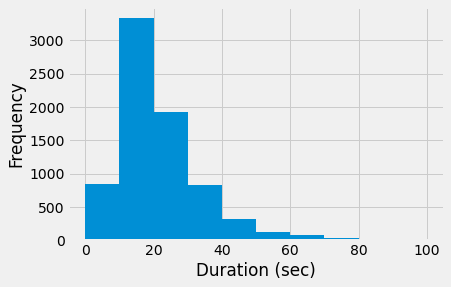

count    7500.000000
mean       21.532651
std        12.485268
min         2.611882
25%        13.113379
50%        18.468571
75%        26.632902
max       149.498776
Name: Duration, dtype: float64


Reciter AbdurrahmaanAs-Sudais


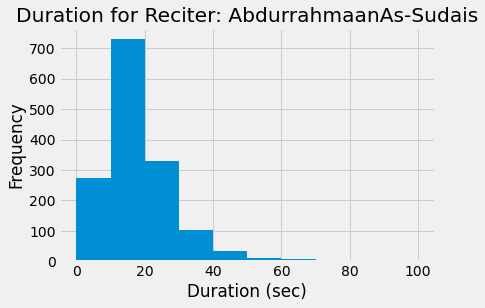

count    1500.000000
mean       18.254597
std        10.526540
min         2.611882
25%        11.180045
50%        15.986576
75%        22.334331
max       117.184943
Name: Duration, dtype: float64


Reciter Ajami


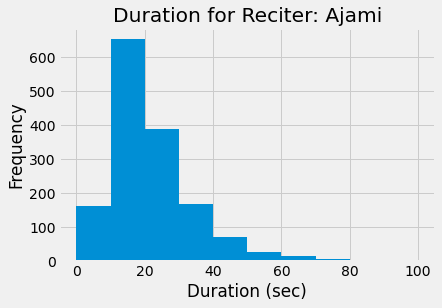

count    1500.000000
mean       21.981813
std        12.694398
min         2.939841
25%        13.643515
50%        18.756984
75%        27.259841
max       136.294943
Name: Duration, dtype: float64


Reciter Alafasy


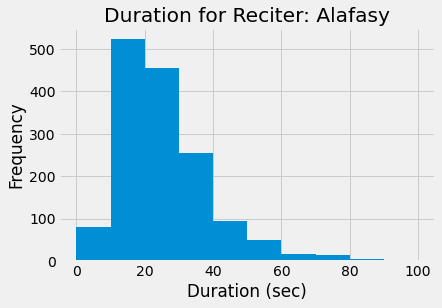

count    1500.000000
mean       25.701808
std        14.104947
min         4.623673
25%        15.908571
50%        22.726531
75%        32.084898
max       144.848980
Name: Duration, dtype: float64


Reciter FaresAbbad


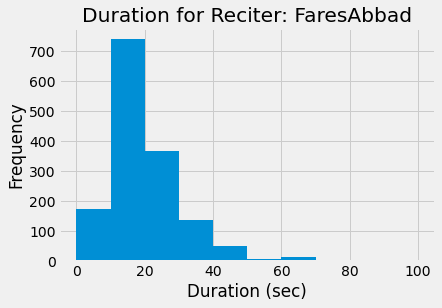

count    1500.000000
mean       20.071375
std        11.190225
min         3.787755
25%        12.688980
50%        17.319184
75%        24.581224
max       136.881633
Name: Duration, dtype: float64


Reciter Ghamadi


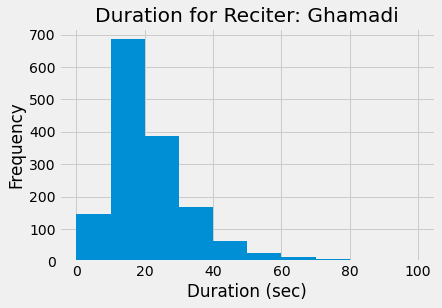

count    1500.000000
mean       21.653664
std        12.377382
min         3.422041
25%        13.178776
50%        18.586122
75%        26.775510
max       149.498776
Name: Duration, dtype: float64




In [54]:
# Overall distribution
sortby_dur = df.sort_values(['Duration'], ascending=True)
sortby_dur['Duration'].plot(kind="hist", bins=10, range=(0,100))
plt.xlabel("Duration (sec)")
plt.show()
print(sortby_dur['Duration'].describe())
print()
print()

# Look at this for each reciter
for rec in list(le.classes_):
    print("Reciter", rec)
    tmp_df  = sortby_dur[sortby_dur['ReciterName'] == rec]
    tmp_df['Duration'].plot(kind="hist", bins=10, range=(0,100))
    my_title = "Duration for Reciter: " + rec 
    plt.title(my_title)
    plt.xlabel("Duration (sec)")
    plt.show()
    print(tmp_df['Duration'].describe())
    print()
    print()

### Train/Test/Validation Duration Distribution Observations

It looks like training set is failry well distributed. Test & Validation datasets can be improved.

It looks like we may need to change the reciter from Abdul Basit to someone else given that his durations are longer compared to other reciters. The mean duration of 38sec is quite larger than means for other reciters in the range of 21-26 sec.

Another question is that so far I am being careful to keep the same Aya for each reciter in the train/val/test data set. Should I experiment where I ignore the Aya and just focus on duration for each reciter?

For Set ==  test


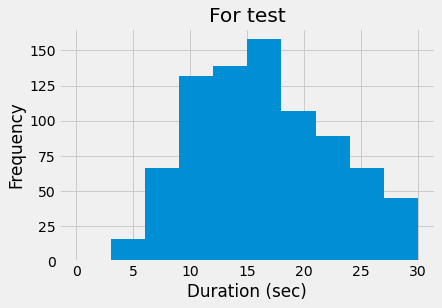

count    1000.000000
mean       20.763288
std        11.597048
min         2.611882
25%        12.833719
50%        17.783390
75%        25.939592
max        93.204898
Name: Duration, dtype: float64


Reciter AbdurrahmaanAs-Sudais


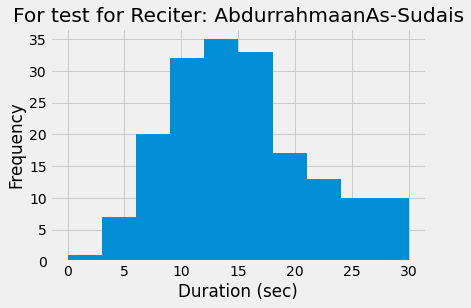

count    200.000000
mean      17.832911
std       10.061293
min        2.611882
25%       11.193107
50%       15.294331
75%       21.949025
max       69.877188
Name: Duration, dtype: float64


Reciter Ajami


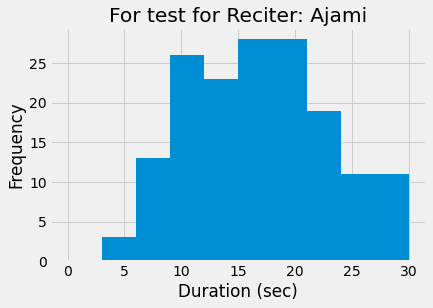

count    200.000000
mean      21.390288
std       11.908463
min        3.984739
25%       13.016576
50%       18.874535
75%       26.672086
max       77.780658
Name: Duration, dtype: float64


Reciter Alafasy


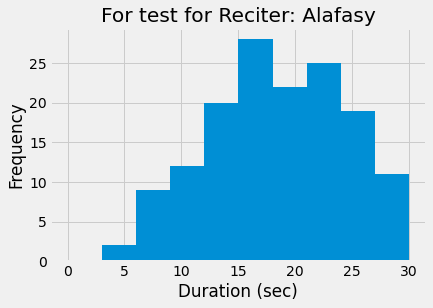

count    200.000000
mean      24.493976
std       13.142162
min        5.616327
25%       15.451429
50%       21.929796
75%       30.791837
max       93.204898
Name: Duration, dtype: float64


Reciter FaresAbbad


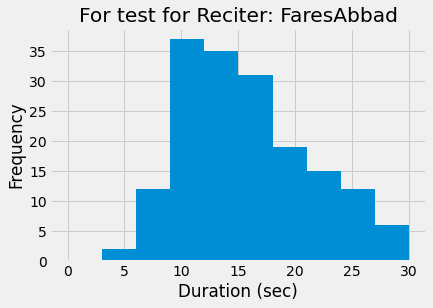

count    200.000000
mean      19.072131
std       10.034056
min        5.250612
25%       11.983673
50%       16.378776
75%       23.673469
max       66.272653
Name: Duration, dtype: float64


Reciter Ghamadi


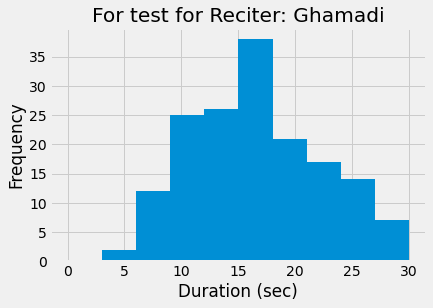

count    200.000000
mean      21.027135
std       11.522303
min        4.675918
25%       13.387755
50%       17.841633
75%       25.417143
max       77.374694
Name: Duration, dtype: float64




In [55]:
my_rec = list(le.classes_)
my_set = 'test'

def show_dur(df=sortby_dur, my_bins=10, my_range=(0,30), my_set=my_set, reciters=my_rec):
    print("For Set == ", my_set)
    df_set = df[df['Set'] == my_set]
    df_set['Duration'].plot(kind="hist", bins=my_bins, range=my_range)
    my_title = "For " + my_set 
    plt.title(my_title)
    plt.xlabel("Duration (sec)")
    plt.show()
    print(df_set['Duration'].describe())
    print()
    print()

    # Look at this for each reciter
    for rec in reciters:
        print("Reciter", rec)
        tmp_df  = df_set[df_set['ReciterName'] == rec]
        tmp_df['Duration'].plot(kind="hist", bins=my_bins, range=my_range)
        my_title = "For " + my_set + " for Reciter: " + rec 
        plt.title(my_title)
        plt.xlabel("Duration (sec)")
        plt.show()
        print(tmp_df['Duration'].describe())
        print()
        print()

my_set = 'test'
show_dur(my_set=my_set)

For Set ==  validation


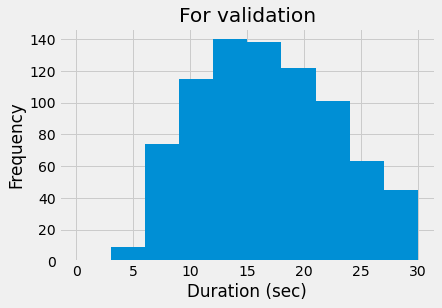

count    1000.000000
mean       21.445731
std        12.226947
min         4.022857
25%        13.241083
50%        18.742676
75%        26.102766
max       117.184943
Name: Duration, dtype: float64


Reciter AbdurrahmaanAs-Sudais


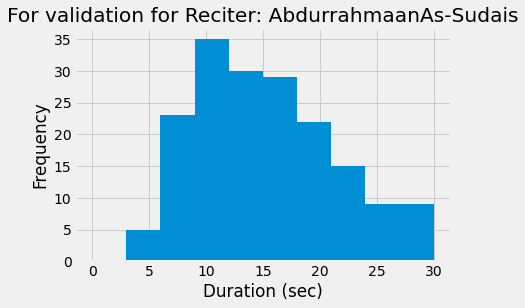

count    200.000000
mean      18.673139
std       12.827647
min        4.780045
25%       11.023311
50%       15.307392
75%       22.549841
max      117.184943
Name: Duration, dtype: float64


Reciter Ajami


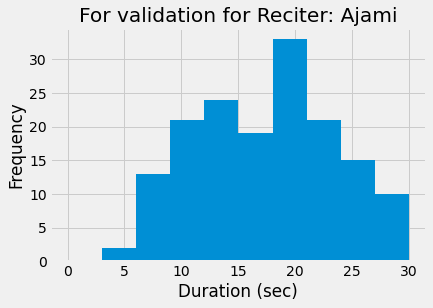

count    200.000000
mean      22.127564
std       11.353518
min        5.421474
25%       13.767596
50%       19.736576
75%       27.135760
max       79.478617
Name: Duration, dtype: float64


Reciter Alafasy


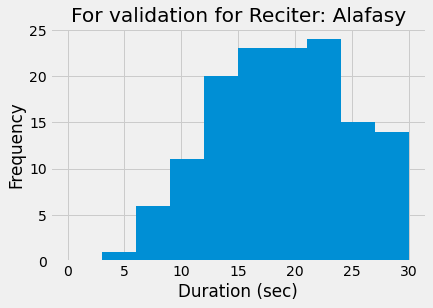

count    200.000000
mean      25.984784
std       13.095938
min        5.903673
25%       16.202449
50%       23.209796
75%       31.875918
max       84.349388
Name: Duration, dtype: float64


Reciter FaresAbbad


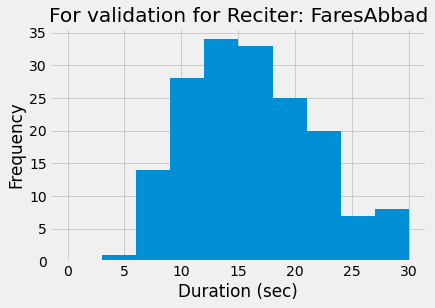

count    200.000000
mean      19.864555
std       11.210143
min        4.022857
25%       12.375510
50%       17.162449
75%       23.373061
max       70.504490
Name: Duration, dtype: float64


Reciter Ghamadi


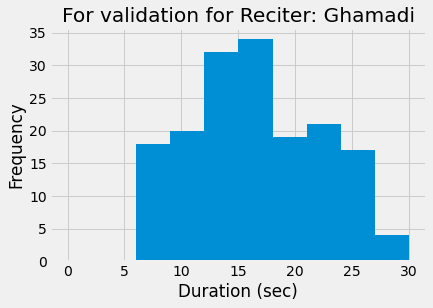

count    200.000000
mean      20.578612
std       11.300721
min        6.922449
25%       13.263673
50%       17.828571
75%       24.855510
max       81.240816
Name: Duration, dtype: float64




In [56]:
my_set = 'validation'
show_dur(my_set=my_set)

For Set ==  train


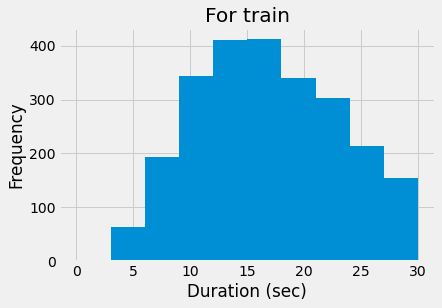

count    3000.000000
mean       21.621034
std        12.971780
min         2.664127
25%        13.113107
50%        18.514637
75%        26.540408
max       149.498776
Name: Duration, dtype: float64


Reciter AbdurrahmaanAs-Sudais


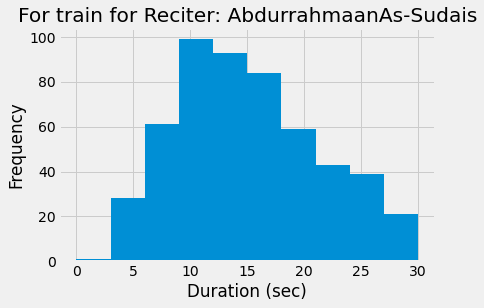

count    600.000000
mean      18.159137
std       10.586801
min        2.664127
25%       11.016780
50%       15.438005
75%       23.078821
max       72.019229
Name: Duration, dtype: float64


Reciter Ajami


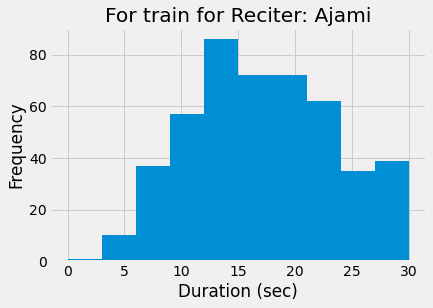

count    600.000000
mean      22.440620
std       13.081901
min        2.939841
25%       13.806780
50%       19.253311
75%       28.533311
max      136.294943
Name: Duration, dtype: float64


Reciter Alafasy


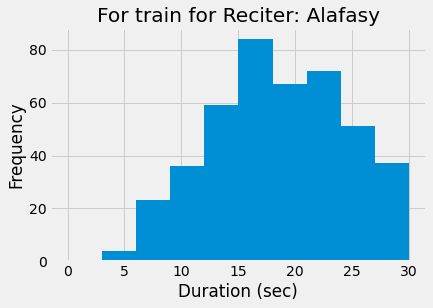

count    600.000000
mean      25.478356
std       14.781535
min        4.623673
25%       15.895510
50%       22.073469
75%       31.673469
max      144.848980
Name: Duration, dtype: float64


Reciter FaresAbbad


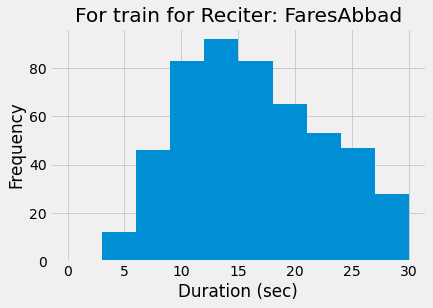

count    600.000000
mean      20.150073
std       11.750292
min        4.127347
25%       12.375510
50%       17.567347
75%       24.803265
max      136.881633
Name: Duration, dtype: float64


Reciter Ghamadi


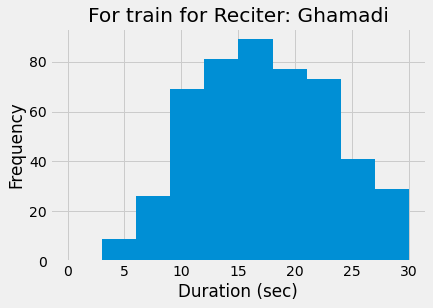

count    600.000000
mean      21.876985
std       13.147820
min        3.526531
25%       13.616327
50%       18.834286
75%       25.391020
max      149.498776
Name: Duration, dtype: float64




In [57]:
my_set = 'train'
show_dur(my_set=my_set)

# Plot duration distribution between train/test/val


In [21]:
#import seaborn as sns

def show_dur_plt(df, reciter, lbl_train='train', lbl_second='test', lbl_third='validation'):
    plt.style.use('fivethirtyeight')
        
    if reciter is not None:
        df_rec = df[(df['ReciterName'] == reciter)]
        overall = df_rec['Duration'].to_numpy()
        my_set = lbl_train
        df_set = df[(df['Set'] == my_set) & (df['ReciterName'] == reciter)]
        train = df_set['Duration'].to_numpy()
        my_set = lbl_second
        df_set = df[(df['Set'] == my_set) & (df['ReciterName'] == reciter)]
        test = df_set['Duration'].to_numpy()
        my_set = lbl_third
        df_set = df[(df['Set'] == my_set) & (df['ReciterName'] == reciter)]
        val = df_set['Duration'].to_numpy()
        my_title = "For Reciter " + reciter
    else:
        overall = df['Duration'].to_numpy()
        my_set = lbl_train
        df_set = df[df['Set'] == my_set]
        train = df_set['Duration'].to_numpy()
        my_set = lbl_second
        df_set = df[df['Set'] == my_set]
        test = df_set['Duration'].to_numpy()
        my_set = lbl_third
        df_set = df[df['Set'] == my_set]
        val = df_set['Duration'].to_numpy()
        my_title = "Overall"  

        
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(16, 10))
        sns.kdeplot(overall, ax=ax, label="Overall", lw=5, alpha=0.6);
        sns.kdeplot(train, ax=ax, label=lbl_train, lw=5, alpha=0.6);
        sns.kdeplot(test, ax=ax, label=lbl_second, lw=5, alpha=0.6);
        sns.kdeplot(val, ax=ax, label=lbl_third, lw=5, alpha=0.6);
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.legend(fontsize=20);
        #my_title = "For " + my_set + " for Reciter: " + rec 
        plt.title(my_title)
        plt.xlabel("Duration (sec)")

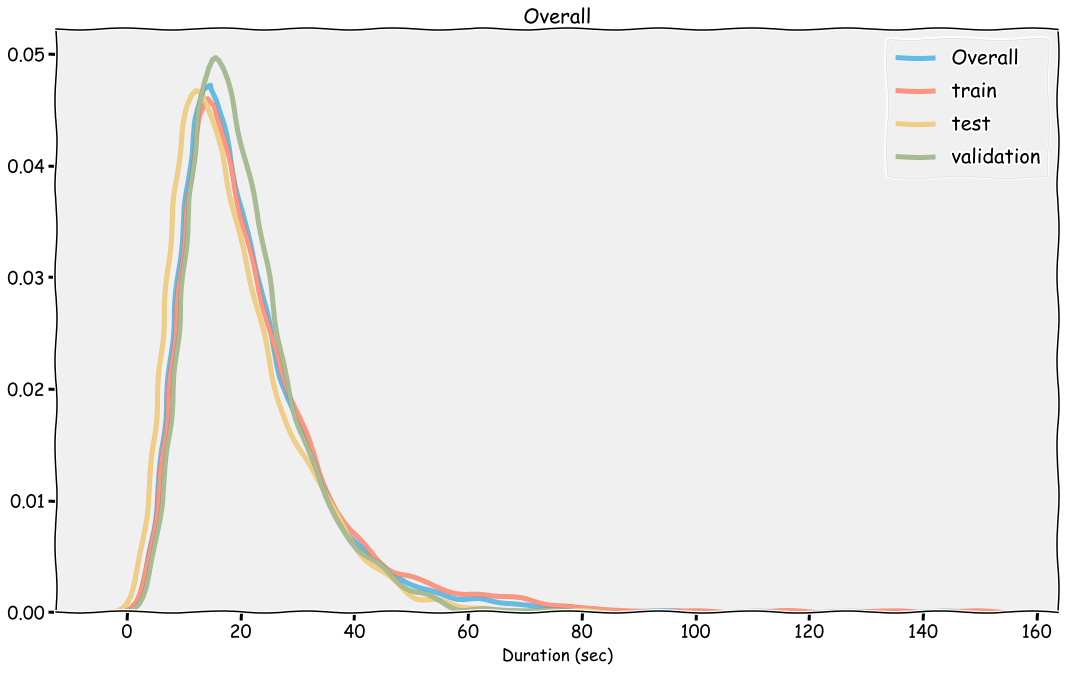

In [22]:
show_dur_plt(df=df, reciter=None)

# Plot duration distribution between train/test/val - For each Reciter


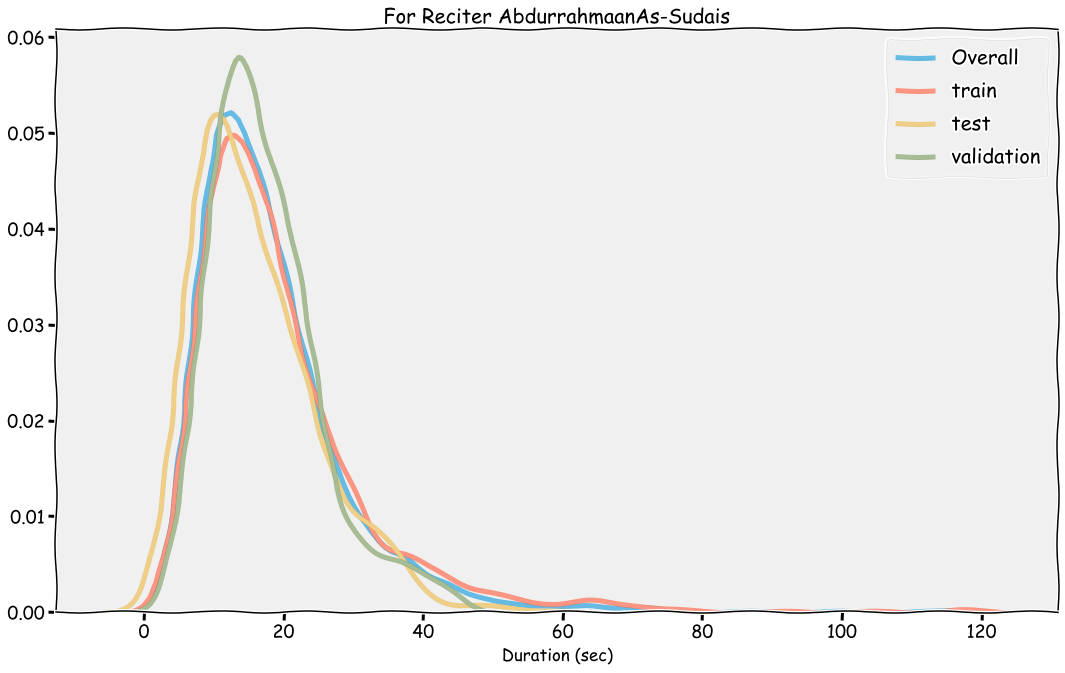

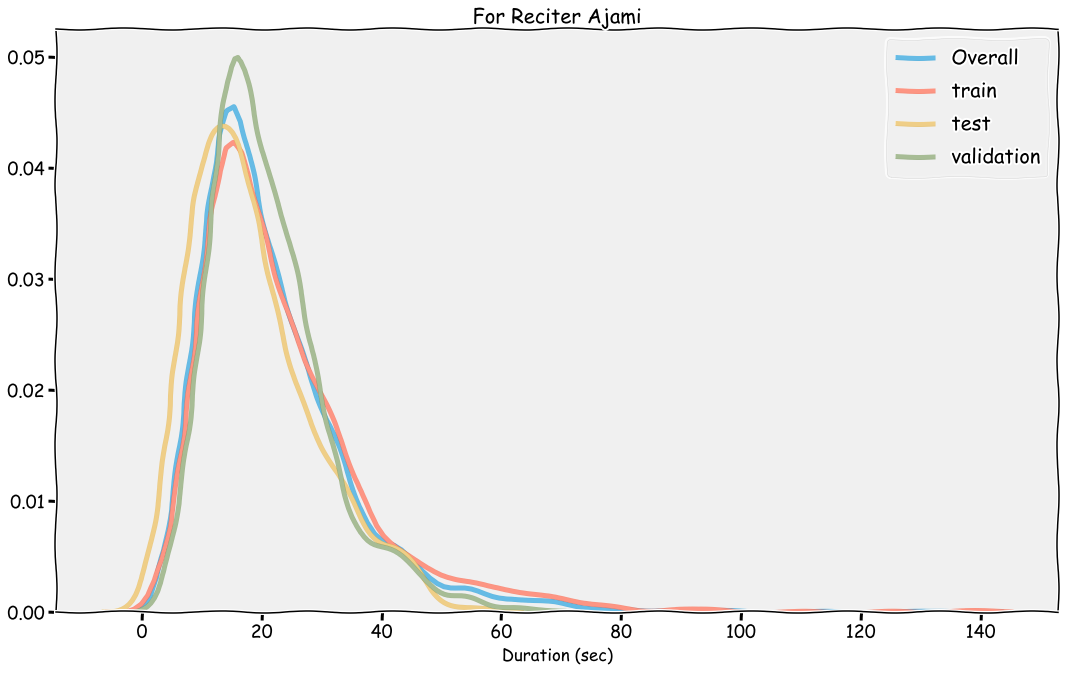

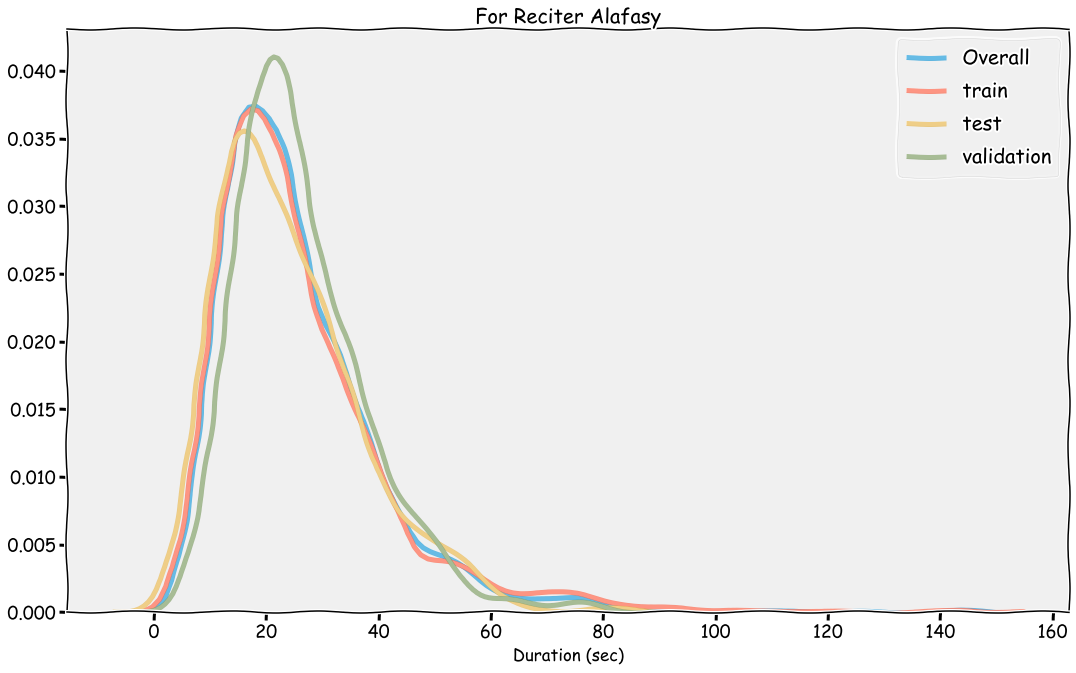

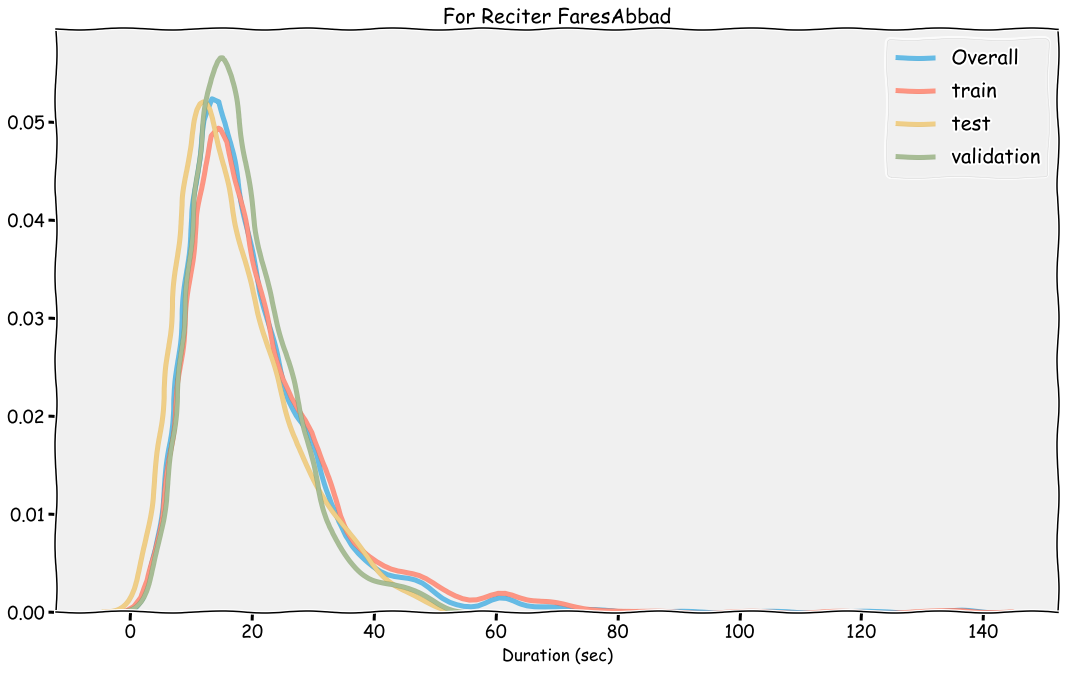

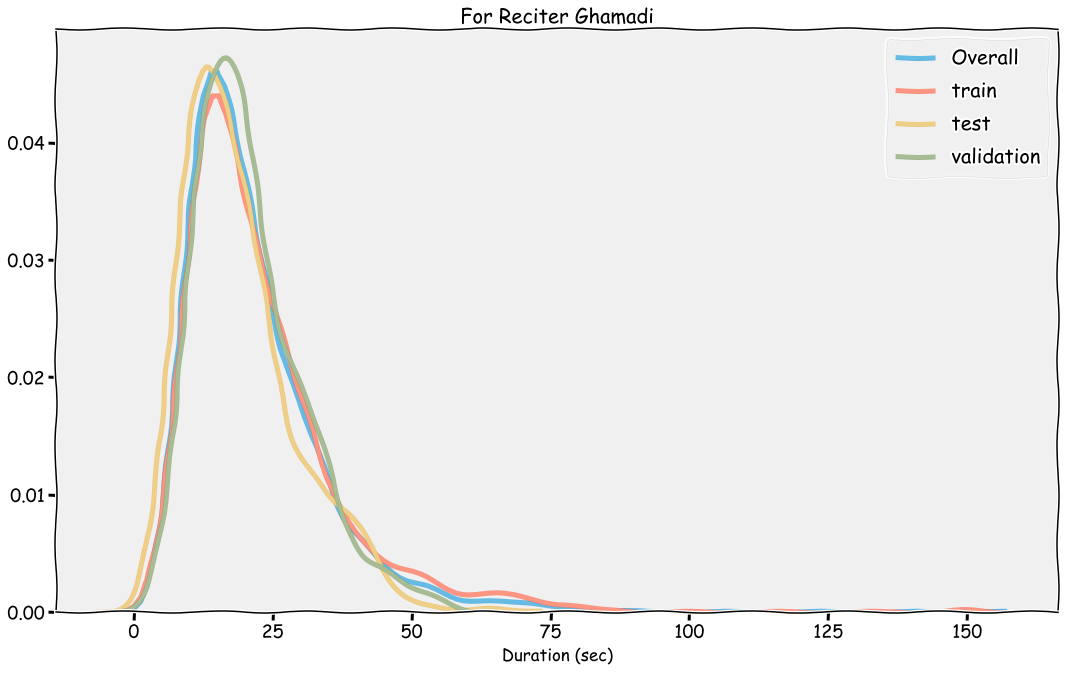

In [23]:
my_rec = list(le.classes_)
for rec in my_rec:
    show_dur_plt(df=df, reciter=rec)

In [17]:
# Save the df 
my_excel_fileA = os.path.join(data_dir, 'pd_df_4.xlsx')
writer = ExcelWriter(my_excel_fileA)
df.to_excel(writer,'Sheet1',index=False)
writer.save()

In [18]:
# Read info saved earlier to save time
my_excel_fileA = os.path.join(data_dir, 'pd_df_4.xlsx')
# Read Excel file
df = pd.read_excel(my_excel_fileA)

In [19]:
# Steps 1-2: Based on total ayas available for each reciter, do some math
ref_reciter = 'Ghamadi'
ayas_per_for_train_test_val = 2. / 3.
test_per = 0.2
val_per = 0.2
train_per = 1. - test_per - val_per

FileNames = list(df['FileName'].unique())
tot_ayas = len(FileNames)
print("Total number of ayas (data points) per reciter = ", tot_ayas)

# Ayas to use from dataset
ayas_to_use = math.floor(ayas_per_for_train_test_val * tot_ayas)
test_ayas   = math.floor(test_per                    * ayas_to_use) 
val_ayas    = math.floor(val_per                     * ayas_to_use) 
train_ayas  = ayas_to_use - test_ayas - val_ayas

print(" Ayas to use = ", ayas_to_use)
print("   Test Ayas = ", test_ayas)
print("    Val Ayas = ", val_ayas)
print("  Train Ayas = ", train_ayas)

# Also reset the 'Set' column in the df
set_na_val = 'NA'
df['Set'] = set_na_val

df.head()

Total number of ayas (data points) per reciter =  1500
 Ayas to use =  1000
   Test Ayas =  200
    Val Ayas =  200
  Train Ayas =  600


,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,NA
1,AbdurrahmaanAs-Sudais,001002.mp3,35,64,2,stereo,4.414331,1002,1,2,1,Yes,NA
2,AbdurrahmaanAs-Sudais,001003.mp3,24,64,2,stereo,3.029841,1003,1,3,2,Yes,NA
3,AbdurrahmaanAs-Sudais,001004.mp3,27,64,2,stereo,3.369433,1004,1,4,3,Yes,NA
4,AbdurrahmaanAs-Sudais,001005.mp3,38,64,2,stereo,4.858413,1005,1,5,4,Yes,NA


In [20]:
ref_reciter = 'Ghamadi'
print("Processing Reciter ", ref_reciter)
print()
print("Step A: Detecting non-unique durations for: ", ref_reciter)
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['Duration'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        #print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print("Step B: Uniquifying durations for: ", ref_reciter)
df_tmp = df.copy()
df_tmp['DurationUnique'] = df_tmp['Duration']

uniq_val_dict = dict()
df_tmp2 = df_tmp.copy()
for i, row in df_tmp.iterrows():
    if row['ReciterName'] == ref_reciter:
        non_unique = freq_dict[row['Duration']]
        if non_unique != 1:
            # First time we encountered this one?
            if row['Duration'] not in uniq_val_dict:
                #print("First time for {}".format(row['Duration']))
                uniq_val_dict[row['Duration']] = 0
            else:
                uniq_val_dict[row['Duration']] += 1
            
            small_value = 0.0000100000001 / non_unique
            uniq_value = row['Duration'] + ( small_value * uniq_val_dict[row['Duration']])
            #uniq_value = 0.0
            #print("non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value)) 
            if uniq_val_dict[row['Duration']] != 0:
                if row['Duration'] != uniq_value:
                    # SUCESSFULLY changed to a non-unique value
                    #row['DurationUnique'] = uniq_value
                    df_tmp2.loc[i,'DurationUnique'] = uniq_value
                    #print("Success! {} Duration = DurationUnique = {}".format(i, row['Duration'] == df_tmp2.loc[i,'DurationUnique']))

                else:
                    print("FAILURE! non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value))

print()
print("Step C: Check #1 for: ", ref_reciter)
df_rec = df_tmp2[(df_tmp2['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print("Step D: Update main df for: ", ref_reciter)
# One satisfied, update the main df
df = df_tmp2.copy()

print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


Processing Reciter  Ghamadi

Step A: Detecting non-unique durations for:  Ghamadi
ERROR: One or more non-unique values found, please fix before continuing!

Step B: Uniquifying durations for:  Ghamadi

Step C: Check #1 for:  Ghamadi
Success: No non-unique values found!

Step D: Update main df for:  Ghamadi

Step E: Check #2 for:  Ghamadi
Success: No non-unique values found!



Step E: Check #2 for:  Ghamadi
Success: No non-unique values found!

Step 3: test for reciter Ghamadi
Number of data points in the distribution = 1500
                             SAMPLING_FOR = test
                              SAMPLE_SIZE = 200
200 ayas Set for: test

Step 4: validation for reciter
Number of data points in the distribution = 1300
                             SAMPLING_FOR = validation
                              SAMPLE_SIZE = 200
200 ayas Set for: validation

Step 5: train for reciter
Number of data points in the distribution = 1100
                             SAMPLING_FOR = train
                              SAMPLE_SIZE = 600
600 ayas Set for: train

Step 6: Updating main df for reciter


,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set,DurationUnique
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,NA,3.003719


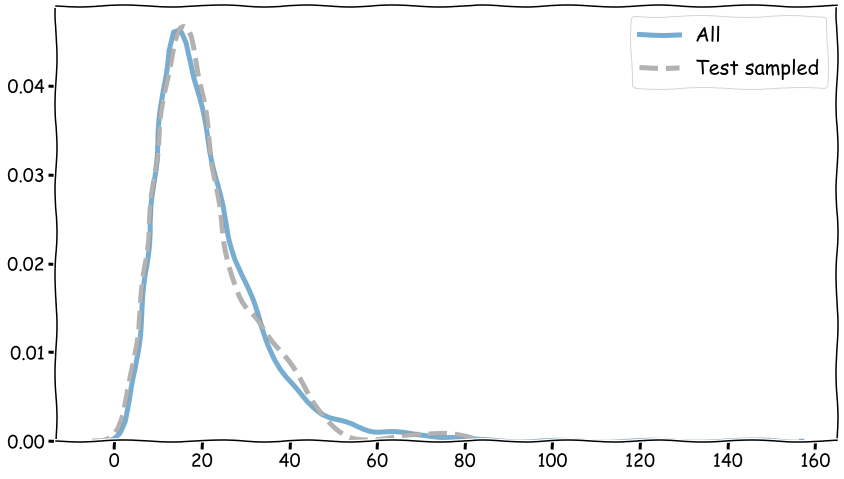

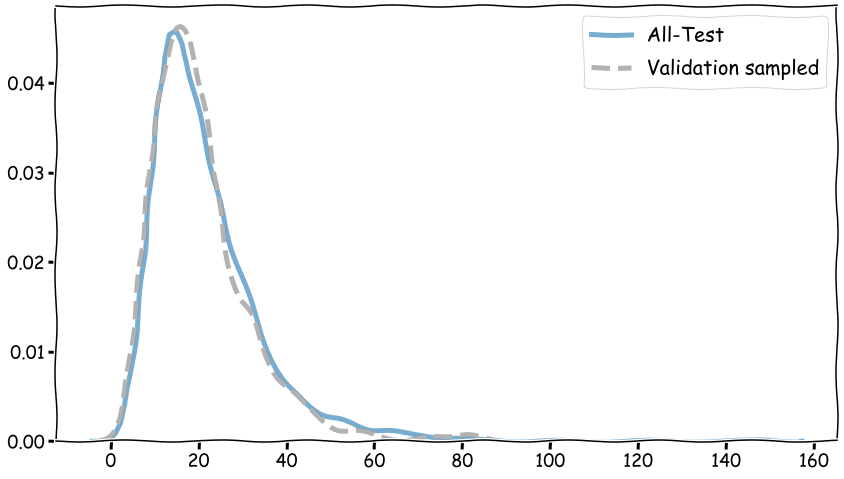

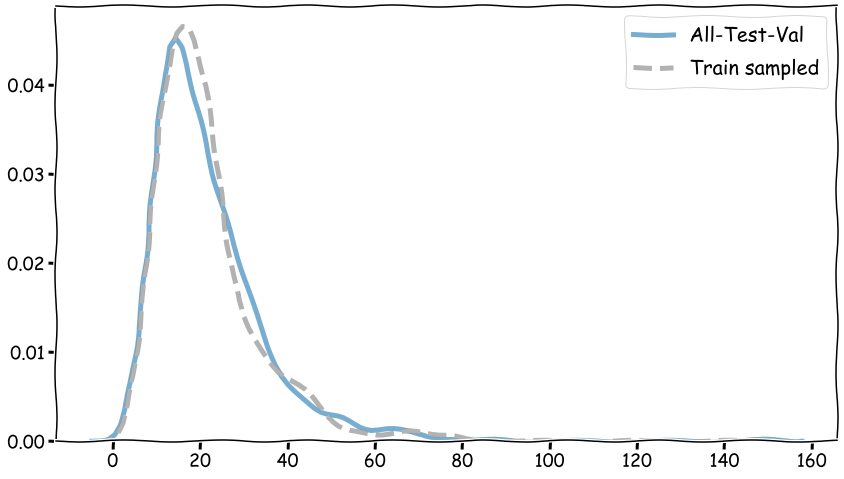

In [21]:
# Make a copy for updates
df_tmp = df.copy()

# Step 3
SAMPLING_FOR       = 'test'
SAMPLE_SIZE        = test_ayas
available_dist_lbl = 'All'
SAMPLING_FOR_lbl   = 'Test sampled'

# WARNING: Looks like reading from csv file is messing up the DurationUnique numbers which are
# most likely getting rounded up/down as we save/read from csv. So need to make sure
# we are always working with the df copy in the memory & never read it from the CSV
# file after uniquification is done!
print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print ("Step {}: {} for reciter {}".format(3, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df[(df['ReciterName'] == ref_reciter)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

available_dist_percentiles = [
    np.percentile(available_dist, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, available_dist_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] == set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))


#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
test = sample

# Step 4
SAMPLING_FOR       = 'validation'
SAMPLE_SIZE        = val_ayas
available_dist_lbl = 'All-Test'
SAMPLING_FOR_lbl   = 'Validation sampled'

print()
print ("Step {}: {} for reciter".format(4, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
validation = sample

# Step 5
SAMPLING_FOR       = 'train'
SAMPLE_SIZE        = train_ayas
available_dist_lbl = 'All-Test-Val'
SAMPLING_FOR_lbl   = 'Train sampled'

print()
print ("Step {}: {} for reciter".format(5, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()
"""
"""


print()
print ("Step {}: Updating main df for reciter".format(6))
# Update the main dataframe after everything looks satisfactory
df = df_tmp.copy()
df.head(1)


In [22]:
ref_reciter = 'AbdurrahmaanAs-Sudais'
print("Processing Reciter ", ref_reciter)
print()
print("Step A: Detecting non-unique durations for: ", ref_reciter)
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['Duration'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        #print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")
    
print()
print("Step B: Uniquifying durations for: ", ref_reciter)
df_tmp = df.copy()
df_tmp['DurationUnique'] = df_tmp['Duration']

uniq_val_dict = dict()
df_tmp2 = df_tmp.copy()
for i, row in df_tmp.iterrows():
    if row['ReciterName'] == ref_reciter:
        non_unique = freq_dict[row['Duration']]
        if non_unique != 1:
            # First time we encountered this one?
            if row['Duration'] not in uniq_val_dict:
                #print("First time for {}".format(row['Duration']))
                uniq_val_dict[row['Duration']] = 0
            else:
                uniq_val_dict[row['Duration']] += 1
            
            small_value = 0.0000000000001 / non_unique
            uniq_value = row['Duration'] + ( small_value * uniq_val_dict[row['Duration']])
            #uniq_value = 0.0
            #print("non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value)) 
            if uniq_val_dict[row['Duration']] != 0:
                if row['Duration'] != uniq_value:
                    # SUCESSFULLY changed to a non-unique value
                    #row['DurationUnique'] = uniq_value
                    df_tmp2.loc[i,'DurationUnique'] = uniq_value
                    #print("Success! {} Duration = DurationUnique = {}".format(i, row['Duration'] == df_tmp2.loc[i,'DurationUnique']))

                else:
                    print("FAILURE! non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value))

print()
print("Step C: Check #1 for: ", ref_reciter)
df_rec = df_tmp2[(df_tmp2['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

print()
print("Step D: Update main df for: ", ref_reciter)
# One satisfied, update the main df
df = df_tmp2.copy()

print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

Processing Reciter  AbdurrahmaanAs-Sudais

Step A: Detecting non-unique durations for:  AbdurrahmaanAs-Sudais
ERROR: One or more non-unique values found, please fix before continuing!

Step B: Uniquifying durations for:  AbdurrahmaanAs-Sudais

Step C: Check #1 for:  AbdurrahmaanAs-Sudais
Success: No non-unique values found!

Step D: Update main df for:  AbdurrahmaanAs-Sudais

Step E: Check #2 for:  AbdurrahmaanAs-Sudais
Success: No non-unique values found!



Step E: Check #2 for:  AbdurrahmaanAs-Sudais
Success: No non-unique values found!

Step 3: test for reciter AbdurrahmaanAs-Sudais
Number of data points in the distribution = 1500
                             SAMPLING_FOR = test
                              SAMPLE_SIZE = 200
200 ayas Set for: test

Step 4: validation for reciter
Number of data points in the distribution = 1300
                             SAMPLING_FOR = validation
                              SAMPLE_SIZE = 200
200 ayas Set for: validation

Step 5: train for reciter
Number of data points in the distribution = 1100
                             SAMPLING_FOR = train
                              SAMPLE_SIZE = 600
600 ayas Set for: train

Step 6: Updating main df for reciter


,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set,DurationUnique
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,train,3.003719


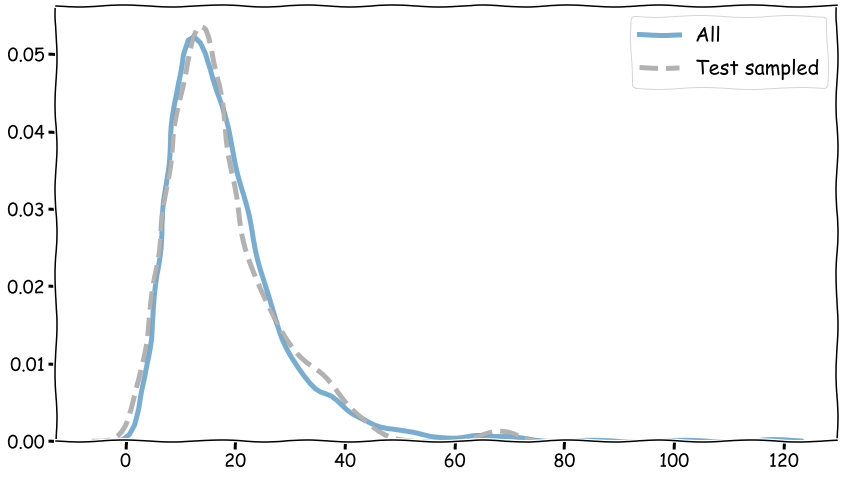

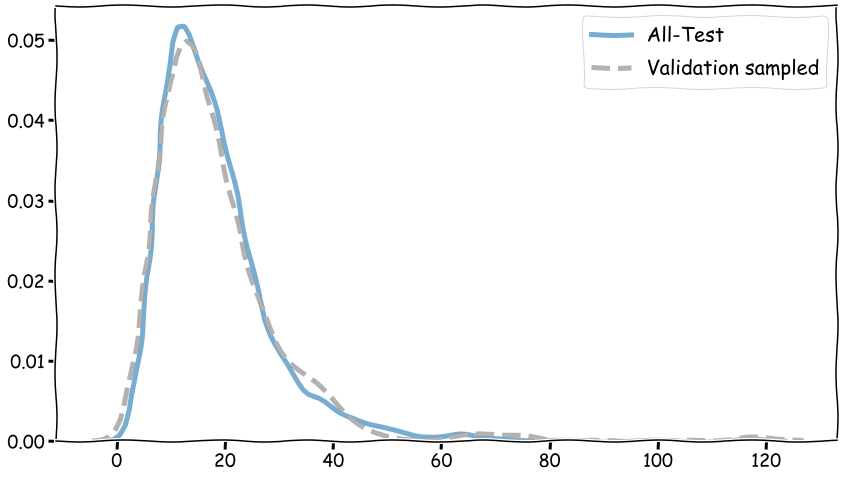

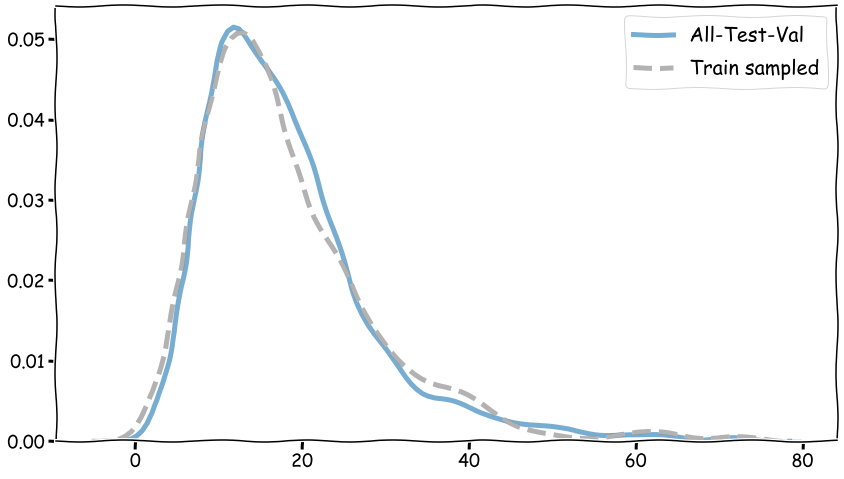

In [23]:
# Make a copy for updates
df_tmp = df.copy()

# Step 3
SAMPLING_FOR       = 'test'
SAMPLE_SIZE        = test_ayas
available_dist_lbl = 'All'
SAMPLING_FOR_lbl   = 'Test sampled'

# WARNING: Looks like reading from csv file is messing up the DurationUnique numbers which are
# most likely getting rounded up/down as we save/read from csv. So need to make sure
# we are always working with the df copy in the memory & never read it from the CSV
# file after uniquification is done!
print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print ("Step {}: {} for reciter {}".format(3, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df[(df['ReciterName'] == ref_reciter)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

available_dist_percentiles = [
    np.percentile(available_dist, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, available_dist_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] == set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))


#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
test = sample

# Step 4
SAMPLING_FOR       = 'validation'
SAMPLE_SIZE        = val_ayas
available_dist_lbl = 'All-Test'
SAMPLING_FOR_lbl   = 'Validation sampled'

print()
print ("Step {}: {} for reciter".format(4, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
validation = sample

# Step 5
SAMPLING_FOR       = 'train'
SAMPLE_SIZE        = train_ayas
available_dist_lbl = 'All-Test-Val'
SAMPLING_FOR_lbl   = 'Train sampled'

print()
print ("Step {}: {} for reciter".format(5, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()
"""
"""


print()
print ("Step {}: Updating main df for reciter".format(6))
# Update the main dataframe after everything looks satisfactory
df = df_tmp.copy()
df.head(1)


In [24]:
ref_reciter = 'Ajami'
print("Processing Reciter ", ref_reciter)
print()
print("Step A: Detecting non-unique durations for: ", ref_reciter)
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['Duration'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        #print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")
    
print()
print("Step B: Uniquifying durations for: ", ref_reciter)
df_tmp = df.copy()
df_tmp['DurationUnique'] = df_tmp['Duration']

uniq_val_dict = dict()
df_tmp2 = df_tmp.copy()
for i, row in df_tmp.iterrows():
    if row['ReciterName'] == ref_reciter:
        non_unique = freq_dict[row['Duration']]
        if non_unique != 1:
            # First time we encountered this one?
            if row['Duration'] not in uniq_val_dict:
                #print("First time for {}".format(row['Duration']))
                uniq_val_dict[row['Duration']] = 0
            else:
                uniq_val_dict[row['Duration']] += 1
            
            small_value = 0.0000000000001 / non_unique
            uniq_value = row['Duration'] + ( small_value * uniq_val_dict[row['Duration']])
            #uniq_value = 0.0
            #print("non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value)) 
            if uniq_val_dict[row['Duration']] != 0:
                if row['Duration'] != uniq_value:
                    # SUCESSFULLY changed to a non-unique value
                    #row['DurationUnique'] = uniq_value
                    df_tmp2.loc[i,'DurationUnique'] = uniq_value
                    #print("Success! {} Duration = DurationUnique = {}".format(i, row['Duration'] == df_tmp2.loc[i,'DurationUnique']))

                else:
                    print("FAILURE! non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value))

print()
print("Step C: Check #1 for: ", ref_reciter)
df_rec = df_tmp2[(df_tmp2['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

print()
print("Step D: Update main df for: ", ref_reciter)
# One satisfied, update the main df
df = df_tmp2.copy()

print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

Processing Reciter  Ajami

Step A: Detecting non-unique durations for:  Ajami
ERROR: One or more non-unique values found, please fix before continuing!

Step B: Uniquifying durations for:  Ajami

Step C: Check #1 for:  Ajami
Success: No non-unique values found!

Step D: Update main df for:  Ajami

Step E: Check #2 for:  Ajami
Success: No non-unique values found!



Step E: Check #2 for:  Ajami
Success: No non-unique values found!

Step 3: test for reciter Ajami
Number of data points in the distribution = 1500
                             SAMPLING_FOR = test
                              SAMPLE_SIZE = 200
200 ayas Set for: test

Step 4: validation for reciter
Number of data points in the distribution = 1300
                             SAMPLING_FOR = validation
                              SAMPLE_SIZE = 200
200 ayas Set for: validation

Step 5: train for reciter
Number of data points in the distribution = 1100
                             SAMPLING_FOR = train
                              SAMPLE_SIZE = 600
600 ayas Set for: train

Step 6: Updating main df for reciter


,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set,DurationUnique
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,train,3.003719


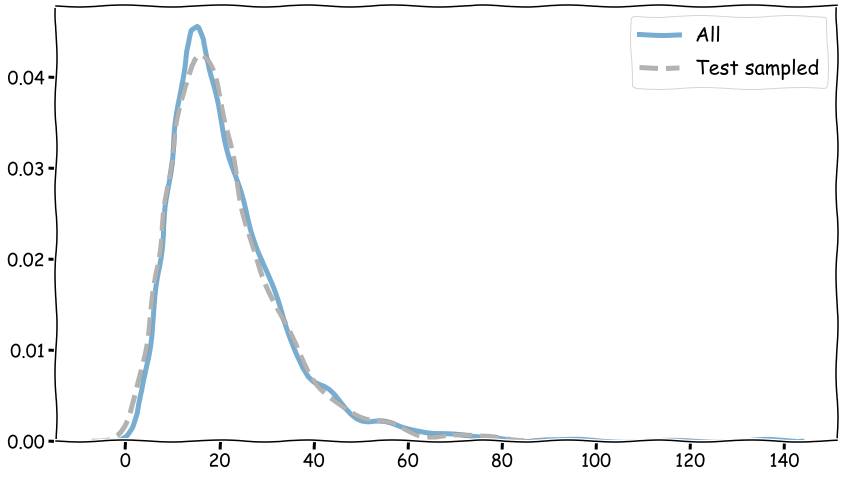

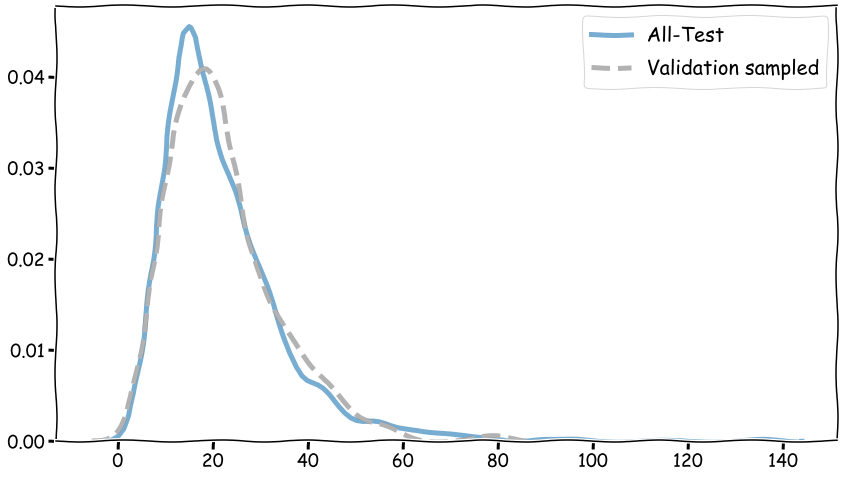

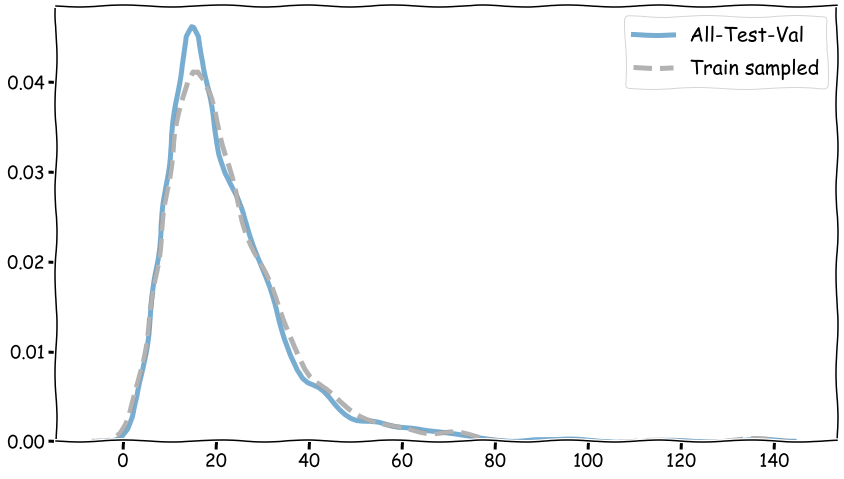

In [25]:
# Make a copy for updates
df_tmp = df.copy()

# Step 3
SAMPLING_FOR       = 'test'
SAMPLE_SIZE        = test_ayas
available_dist_lbl = 'All'
SAMPLING_FOR_lbl   = 'Test sampled'

# WARNING: Looks like reading from csv file is messing up the DurationUnique numbers which are
# most likely getting rounded up/down as we save/read from csv. So need to make sure
# we are always working with the df copy in the memory & never read it from the CSV
# file after uniquification is done!
print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print ("Step {}: {} for reciter {}".format(3, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df[(df['ReciterName'] == ref_reciter)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

available_dist_percentiles = [
    np.percentile(available_dist, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, available_dist_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] == set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))


#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
test = sample

# Step 4
SAMPLING_FOR       = 'validation'
SAMPLE_SIZE        = val_ayas
available_dist_lbl = 'All-Test'
SAMPLING_FOR_lbl   = 'Validation sampled'

print()
print ("Step {}: {} for reciter".format(4, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
validation = sample

# Step 5
SAMPLING_FOR       = 'train'
SAMPLE_SIZE        = train_ayas
available_dist_lbl = 'All-Test-Val'
SAMPLING_FOR_lbl   = 'Train sampled'

print()
print ("Step {}: {} for reciter".format(5, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()
"""
"""


print()
print ("Step {}: Updating main df for reciter".format(6))
# Update the main dataframe after everything looks satisfactory
df = df_tmp.copy()
df.head(1)


In [26]:
ref_reciter = 'Alafasy'
print("Processing Reciter ", ref_reciter)
print()
print("Step A: Detecting non-unique durations for: ", ref_reciter)
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['Duration'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        #print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")
    
print()
print("Step B: Uniquifying durations for: ", ref_reciter)
df_tmp = df.copy()
df_tmp['DurationUnique'] = df_tmp['Duration']

uniq_val_dict = dict()
df_tmp2 = df_tmp.copy()
for i, row in df_tmp.iterrows():
    if row['ReciterName'] == ref_reciter:
        non_unique = freq_dict[row['Duration']]
        if non_unique != 1:
            # First time we encountered this one?
            if row['Duration'] not in uniq_val_dict:
                #print("First time for {}".format(row['Duration']))
                uniq_val_dict[row['Duration']] = 0
            else:
                uniq_val_dict[row['Duration']] += 1
            
            small_value = 0.0000000000001 / non_unique
            uniq_value = row['Duration'] + ( small_value * uniq_val_dict[row['Duration']])
            #uniq_value = 0.0
            #print("non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value)) 
            if uniq_val_dict[row['Duration']] != 0:
                if row['Duration'] != uniq_value:
                    # SUCESSFULLY changed to a non-unique value
                    #row['DurationUnique'] = uniq_value
                    df_tmp2.loc[i,'DurationUnique'] = uniq_value
                    #print("Success! {} Duration = DurationUnique = {}".format(i, row['Duration'] == df_tmp2.loc[i,'DurationUnique']))

                else:
                    print("FAILURE! non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value))

print()
print("Step C: Check #1 for: ", ref_reciter)
df_rec = df_tmp2[(df_tmp2['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

print()
print("Step D: Update main df for: ", ref_reciter)
# One satisfied, update the main df
df = df_tmp2.copy()

print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

Processing Reciter  Alafasy

Step A: Detecting non-unique durations for:  Alafasy
ERROR: One or more non-unique values found, please fix before continuing!

Step B: Uniquifying durations for:  Alafasy

Step C: Check #1 for:  Alafasy
Success: No non-unique values found!

Step D: Update main df for:  Alafasy

Step E: Check #2 for:  Alafasy
Success: No non-unique values found!



Step E: Check #2 for:  Alafasy
Success: No non-unique values found!

Step 3: test for reciter Alafasy
Number of data points in the distribution = 1500
                             SAMPLING_FOR = test
                              SAMPLE_SIZE = 200
200 ayas Set for: test

Step 4: validation for reciter
Number of data points in the distribution = 1300
                             SAMPLING_FOR = validation
                              SAMPLE_SIZE = 200
200 ayas Set for: validation

Step 5: train for reciter
Number of data points in the distribution = 1100
                             SAMPLING_FOR = train
                              SAMPLE_SIZE = 600
600 ayas Set for: train

Step 6: Updating main df for reciter


,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set,DurationUnique
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,train,3.003719


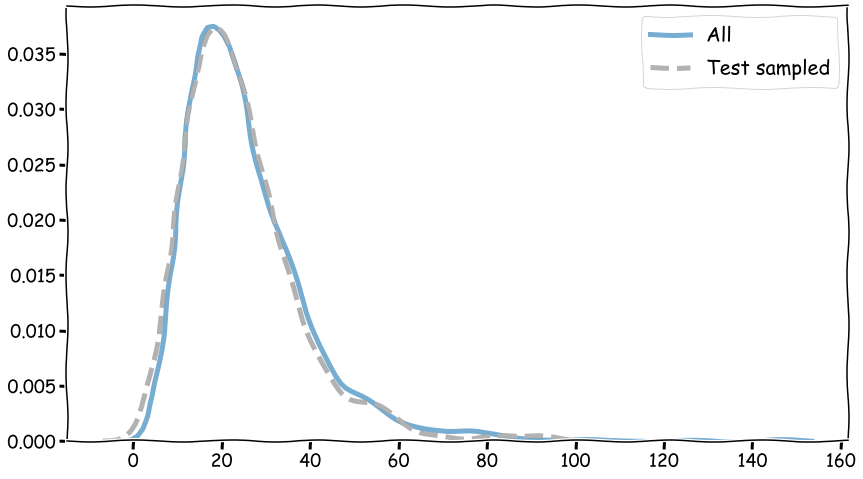

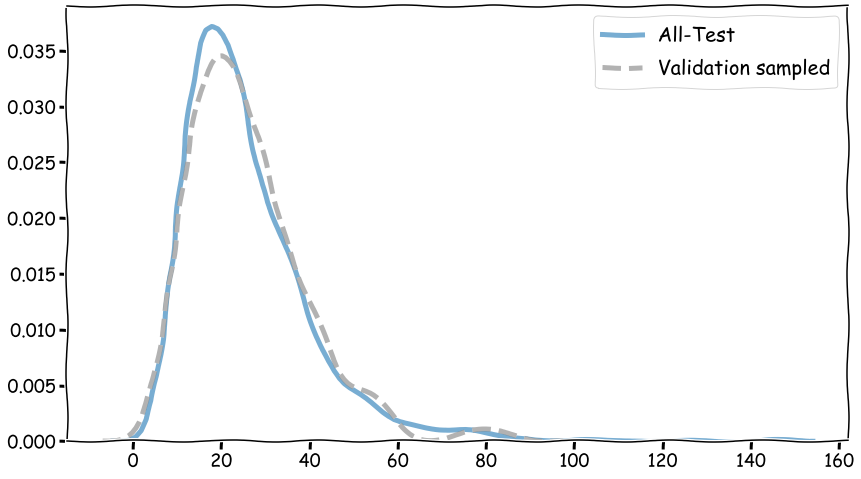

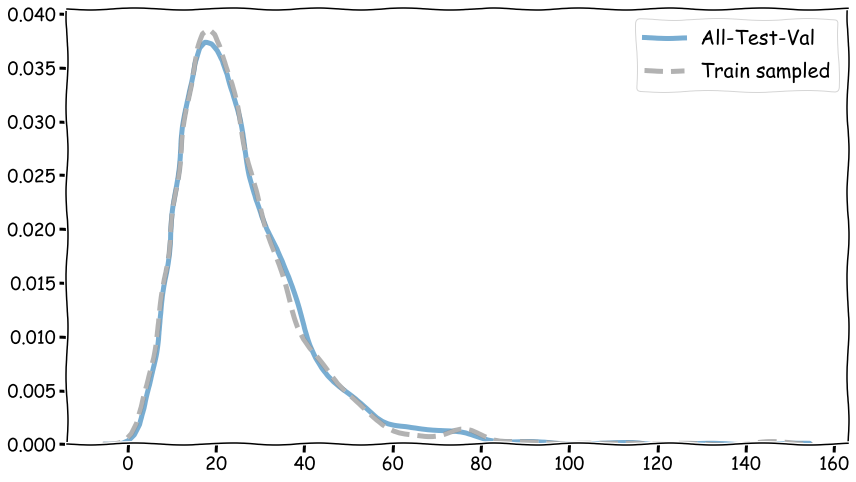

In [27]:
# Make a copy for updates
df_tmp = df.copy()

# Step 3
SAMPLING_FOR       = 'test'
SAMPLE_SIZE        = test_ayas
available_dist_lbl = 'All'
SAMPLING_FOR_lbl   = 'Test sampled'

# WARNING: Looks like reading from csv file is messing up the DurationUnique numbers which are
# most likely getting rounded up/down as we save/read from csv. So need to make sure
# we are always working with the df copy in the memory & never read it from the CSV
# file after uniquification is done!
print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print ("Step {}: {} for reciter {}".format(3, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df[(df['ReciterName'] == ref_reciter)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

available_dist_percentiles = [
    np.percentile(available_dist, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, available_dist_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] == set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))


#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
test = sample

# Step 4
SAMPLING_FOR       = 'validation'
SAMPLE_SIZE        = val_ayas
available_dist_lbl = 'All-Test'
SAMPLING_FOR_lbl   = 'Validation sampled'

print()
print ("Step {}: {} for reciter".format(4, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
validation = sample

# Step 5
SAMPLING_FOR       = 'train'
SAMPLE_SIZE        = train_ayas
available_dist_lbl = 'All-Test-Val'
SAMPLING_FOR_lbl   = 'Train sampled'

print()
print ("Step {}: {} for reciter".format(5, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()
"""
"""


print()
print ("Step {}: Updating main df for reciter".format(6))
# Update the main dataframe after everything looks satisfactory
df = df_tmp.copy()
df.head(1)


In [28]:
ref_reciter = 'FaresAbbad'
print("Processing Reciter ", ref_reciter)
print()
print("Step A: Detecting non-unique durations for: ", ref_reciter)
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['Duration'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        #print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")
    
print()
print("Step B: Uniquifying durations for: ", ref_reciter)
df_tmp = df.copy()
df_tmp['DurationUnique'] = df_tmp['Duration']

uniq_val_dict = dict()
df_tmp2 = df_tmp.copy()
for i, row in df_tmp.iterrows():
    if row['ReciterName'] == ref_reciter:
        non_unique = freq_dict[row['Duration']]
        if non_unique != 1:
            # First time we encountered this one?
            if row['Duration'] not in uniq_val_dict:
                #print("First time for {}".format(row['Duration']))
                uniq_val_dict[row['Duration']] = 0
            else:
                uniq_val_dict[row['Duration']] += 1
            
            small_value = 0.0000000000001 / non_unique
            uniq_value = row['Duration'] + ( small_value * uniq_val_dict[row['Duration']])
            #uniq_value = 0.0
            #print("non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value)) 
            if uniq_val_dict[row['Duration']] != 0:
                if row['Duration'] != uniq_value:
                    # SUCESSFULLY changed to a non-unique value
                    #row['DurationUnique'] = uniq_value
                    df_tmp2.loc[i,'DurationUnique'] = uniq_value
                    #print("Success! {} Duration = DurationUnique = {}".format(i, row['Duration'] == df_tmp2.loc[i,'DurationUnique']))

                else:
                    print("FAILURE! non_unique = {}, value = {}, uniq_val_dict {}, uniq_value {}, {}".format(non_unique, row['Duration'], uniq_val_dict[row['Duration']], uniq_value, row['Duration'] == uniq_value))

print()
print("Step C: Check #1 for: ", ref_reciter)
df_rec = df_tmp2[(df_tmp2['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))

one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

print()
print("Step D: Update main df for: ", ref_reciter)
# One satisfied, update the main df
df = df_tmp2.copy()

print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")

Processing Reciter  FaresAbbad

Step A: Detecting non-unique durations for:  FaresAbbad
ERROR: One or more non-unique values found, please fix before continuing!

Step B: Uniquifying durations for:  FaresAbbad

Step C: Check #1 for:  FaresAbbad
Success: No non-unique values found!

Step D: Update main df for:  FaresAbbad

Step E: Check #2 for:  FaresAbbad
Success: No non-unique values found!



Step E: Check #2 for:  FaresAbbad
Success: No non-unique values found!

Step 3: test for reciter FaresAbbad
Number of data points in the distribution = 1500
                             SAMPLING_FOR = test
                              SAMPLE_SIZE = 200
200 ayas Set for: test

Step 4: validation for reciter
Number of data points in the distribution = 1300
                             SAMPLING_FOR = validation
                              SAMPLE_SIZE = 200
200 ayas Set for: validation

Step 5: train for reciter
Number of data points in the distribution = 1100
                             SAMPLING_FOR = train
                              SAMPLE_SIZE = 600
600 ayas Set for: train

Step 6: Updating main df for reciter


,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set,DurationUnique
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,1001,1,1,0,Yes,train,3.003719


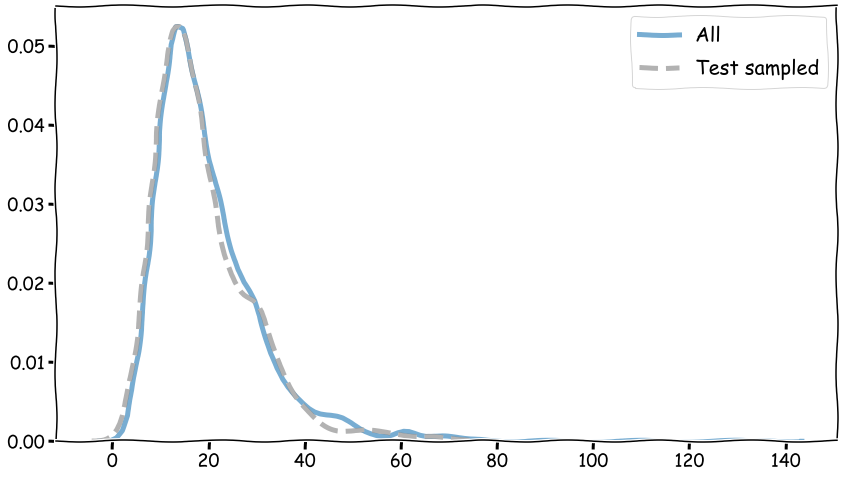

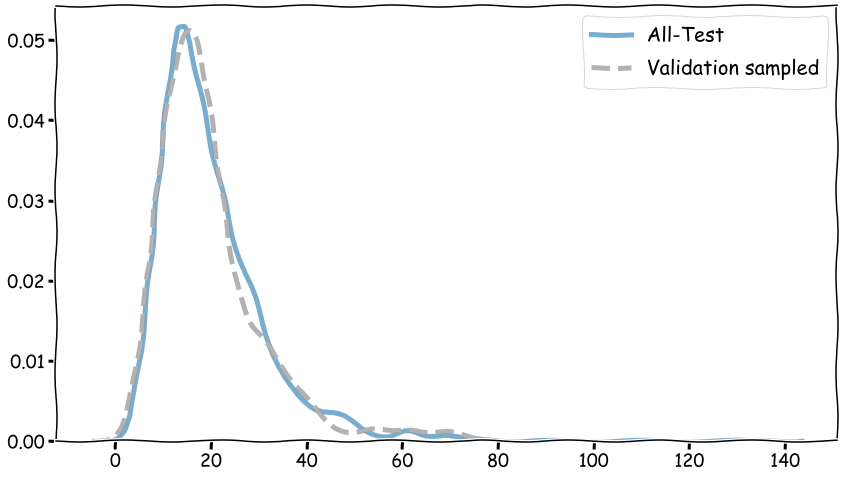

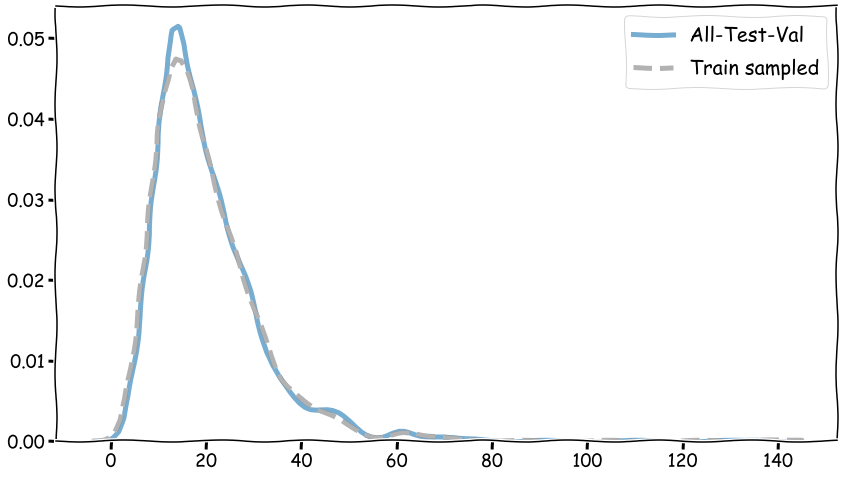

In [29]:
# Make a copy for updates
df_tmp = df.copy()

# Step 3
SAMPLING_FOR       = 'test'
SAMPLE_SIZE        = test_ayas
available_dist_lbl = 'All'
SAMPLING_FOR_lbl   = 'Test sampled'

# WARNING: Looks like reading from csv file is messing up the DurationUnique numbers which are
# most likely getting rounded up/down as we save/read from csv. So need to make sure
# we are always working with the df copy in the memory & never read it from the CSV
# file after uniquification is done!
print()
print("Step E: Check #2 for: ", ref_reciter)
# Do the check again to be sure
df_rec = df[(df['ReciterName'] == ref_reciter)]
train = df_rec['DurationUnique'].to_numpy()

# Make sure there is no overlap in durations, i.e. they are all unique becuase we will use
# them to map back to an Aya
(unique, counts) = np.unique(train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_dict = dict(zip(list(unique), list(counts)))
one_non_uniq_found = 0
for i, cnt in np.ndenumerate(counts):
    if cnt != 1:
        print("Non-unique {} : {} : {}, {}".format(i, cnt, unique[i], freq_dict[unique[i]]))
        one_non_uniq_found += 1
        
if one_non_uniq_found != 0:
    print("ERROR: One or more non-unique values found, please fix before continuing!")
else:
    print("Success: No non-unique values found!")


print()
print ("Step {}: {} for reciter {}".format(3, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df[(df['ReciterName'] == ref_reciter)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

available_dist_percentiles = [
    np.percentile(available_dist, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, available_dist_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] == set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))


#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
test = sample

# Step 4
SAMPLING_FOR       = 'validation'
SAMPLE_SIZE        = val_ayas
available_dist_lbl = 'All-Test'
SAMPLING_FOR_lbl   = 'Validation sampled'

print()
print ("Step {}: {} for reciter".format(4, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()

# Save samples as test
validation = sample

# Step 5
SAMPLING_FOR       = 'train'
SAMPLE_SIZE        = train_ayas
available_dist_lbl = 'All-Test-Val'
SAMPLING_FOR_lbl   = 'Train sampled'

print()
print ("Step {}: {} for reciter".format(5, SAMPLING_FOR, ref_reciter))

# Create the overall data points distribution to draw from
df_rec = df_tmp[(df_tmp['ReciterName'] == ref_reciter) & (df_tmp['Set'] == set_na_val)]
available_dist = df_rec['DurationUnique'].to_numpy()

# Print some stats
print("Number of data points in the distribution = {}".format(len(available_dist)))
print("                             SAMPLING_FOR = {}".format(SAMPLING_FOR))
print("                              SAMPLE_SIZE = {}".format(SAMPLE_SIZE))

N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS

test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
available_dist_bins = np.digitize(available_dist, test_percentiles)

# Count the number of values in each training set bin
available_dist_bin_counts = np.bincount(available_dist_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([available_dist_bin_counts[x] for x in available_dist_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(available_dist, size=SAMPLE_SIZE, p=weights_norm, replace=False)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.kdeplot(available_dist, ax=ax, label=available_dist_lbl, lw=5, alpha=0.6);
    #sns.kdeplot(test, ax=ax, label='Test', lw=5, alpha=0.6);
    sns.kdeplot(sample, ax=ax, label=SAMPLING_FOR_lbl, lw=5, ls='--', color='gray', alpha=0.6);
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20);

# Mark this sample as 'test' in the df 'Set'
mark_cnt = 0
for i, row in df.iterrows():
    if row['ReciterName'] == ref_reciter:
        if row['DurationUnique'] in sample:
            if df_tmp.loc[i,'Set'] is set_na_val:
                df_tmp.loc[i,'Set'] = SAMPLING_FOR
                mark_cnt += 1
            else:
                print("ERROR: {} 'Set' is already marked as {}".format(i, df_tmp.loc[i,'Set']))

print("{} ayas Set for: {}".format(mark_cnt, SAMPLING_FOR))

if SAMPLE_SIZE != mark_cnt:
    print("ERROR: Expected to Set {} ayas, but only {} were Set, please fix".format(SAMPLE_SIZE, mark_cnt))
    
#df_tmp[df_tmp['Set'] == SAMPLING_FOR].head()
"""
"""


print()
print ("Step {}: Updating main df for reciter".format(6))
# Update the main dataframe after everything looks satisfactory
df = df_tmp.copy()
df.head(1)


In [30]:
# Save the df
my_excel_fileA = os.path.join(data_dir, 'pd_df_6.xlsx')
writer = ExcelWriter(my_excel_fileA)
df.to_excel(writer,'Sheet1',index=False)
writer.save()

# Getting similar Duration Distribution between train/test/validation

Here is the process to get similar duration distributions between train/test/validation:

1. Assume all data is available for sampling
2. Assume we can't use 100% of the data for train/test/validation because it will be excluded from the distribution. e.g. to get train+test+validation = 100 data points, we need at least ~150 data points (i.e. 1/3 of data will not meet distribution criteria). So with 150% data available, we will only use 100% of the data points.
3. With **100%** data points, sample **20% for test** using **100% data distribution**, then **remove** test points so they don't get sampled again.
4. With **80%** data points, sample **20% for validation** using **test** data distribution, then **remove** validation points so they don't get sampled again.
5. With **60%** data points, sample **60% for training** using **test** data distribution.
6. Check the distributions of train/test/val to see if they have **similar** distributions.


In [31]:
def show_dur_plt_2(df, reciter, dur_column, lbl_train='train', lbl_second='test', lbl_third='validation'):
    plt.style.use('fivethirtyeight')
        
    if reciter is not None:
        df_rec = df[(df['ReciterName'] == reciter)]
        overall = df_rec[dur_column].to_numpy()
        my_set = lbl_train
        df_set = df[(df['Set'] == my_set) & (df['ReciterName'] == reciter)]
        train = df_set[dur_column].to_numpy()
        my_set = lbl_second
        df_set = df[(df['Set'] == my_set) & (df['ReciterName'] == reciter)]
        test = df_set[dur_column].to_numpy()
        my_set = lbl_third
        df_set = df[(df['Set'] == my_set) & (df['ReciterName'] == reciter)]
        val = df_set[dur_column].to_numpy()
        my_title = "For Reciter " + reciter
    else:
        overall = df[dur_column].to_numpy()
        my_set = lbl_train
        df_set = df[df['Set'] == my_set]
        train = df_set[dur_column].to_numpy()
        my_set = lbl_second
        df_set = df[df['Set'] == my_set]
        test = df_set[dur_column].to_numpy()
        my_set = lbl_third
        df_set = df[df['Set'] == my_set]
        val = df_set[dur_column].to_numpy()
        my_title = "Overall"  

        
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(16, 10))
        #sns.kdeplot(overall, ax=ax, label="Overall", lw=5, alpha=0.6);
        sns.kdeplot(train, ax=ax, label=lbl_train, lw=5, alpha=0.6);
        sns.kdeplot(test, ax=ax, label=lbl_second, lw=5, alpha=0.6);
        sns.kdeplot(val, ax=ax, label=lbl_third, lw=5, alpha=0.6);
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.legend(fontsize=20);
        #my_title = "For " + my_set + " for Reciter: " + rec 
        plt.title(my_title)
        plt.xlabel("{} (sec)".format(dur_column))

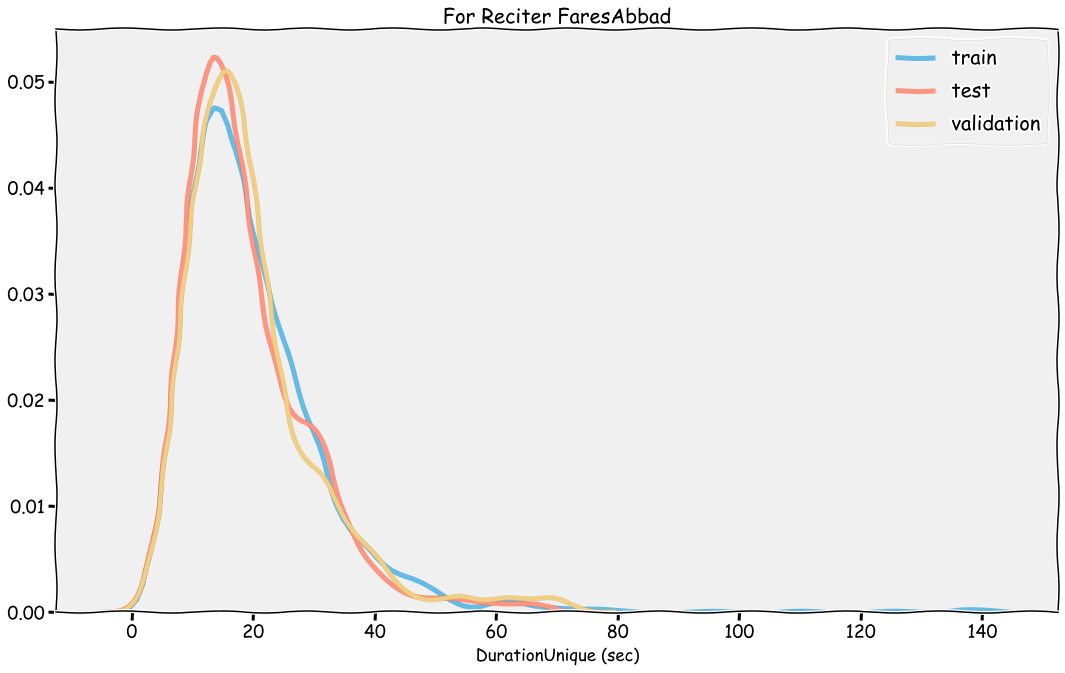

In [32]:
show_dur_plt_2(df=df, reciter=ref_reciter, dur_column='DurationUnique')

# Look at the distribution for rest of reciters
Look at the distributions for each reciter to see if they are similar.

In [40]:
# Update the main dataframe after everything looks satisfactory
df = df_tmp.copy()
df.head(1)

,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran,Common,Set,DurationUnique
0,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,001001,1,1,0,Yes,train,3.003719


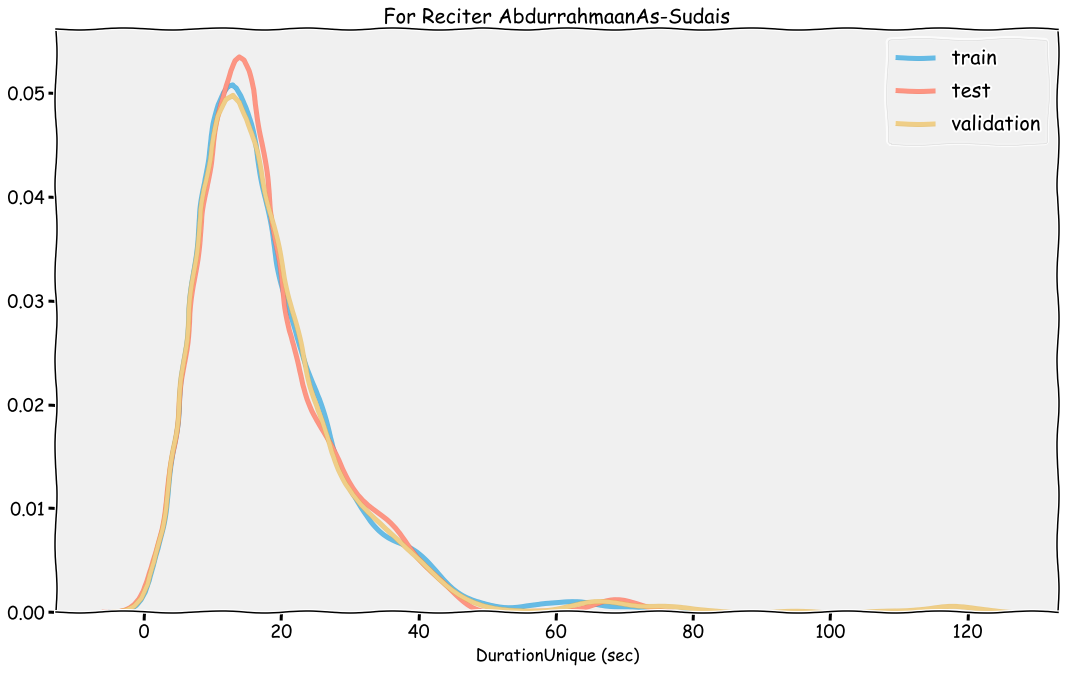

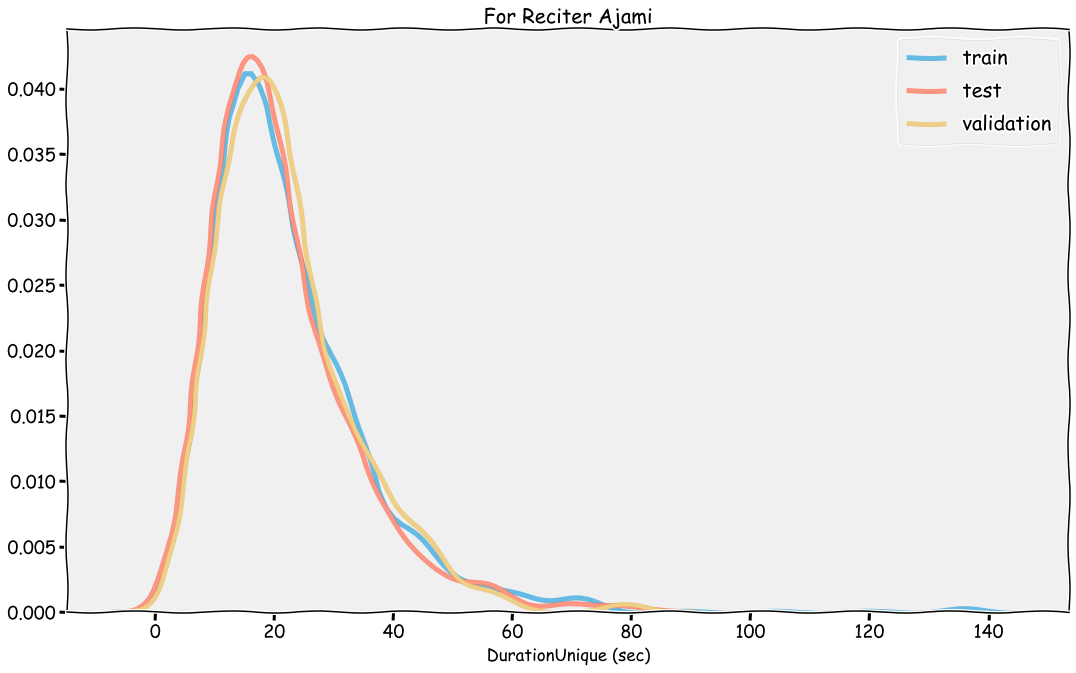

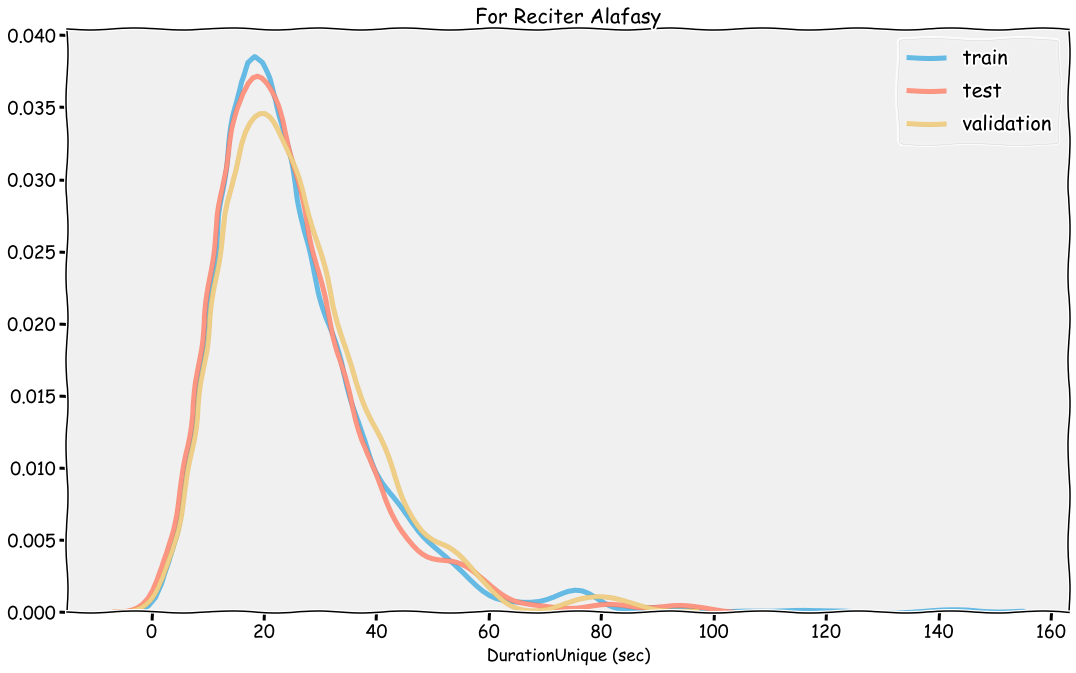

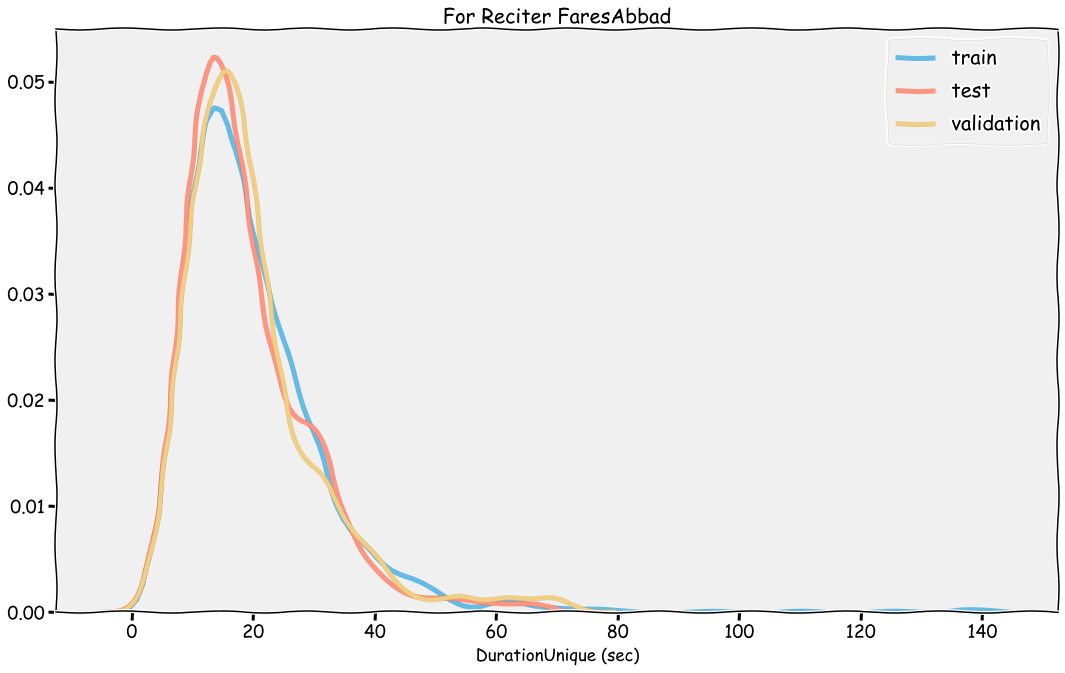

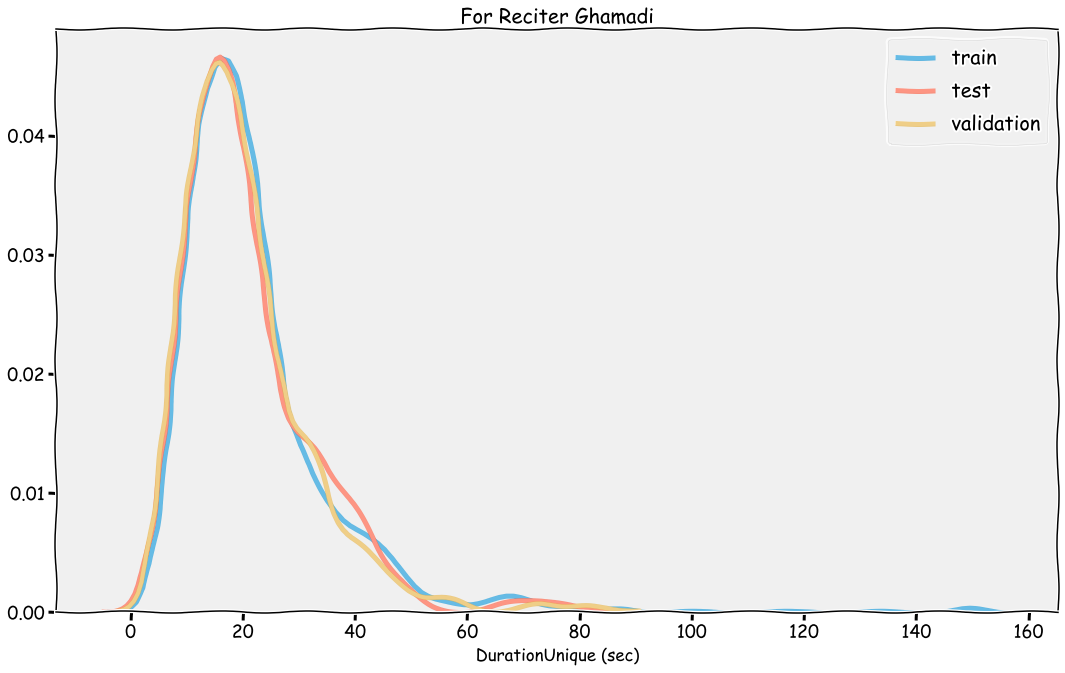

In [33]:
my_rec = list(le.classes_)
for rec in my_rec:
    show_dur_plt_2(df=df, reciter=rec, dur_column='DurationUnique')

In [34]:
# Check the shapes
print("test: ",df[df['Set'] == "test"].shape)
print("validation: ",df[df['Set'] == "validation"].shape)
print("train: ",df[df['Set'] == "train"].shape)

df_test  = df[df['Set'] == "test"]
df_valid = df[df['Set'] == "validation"]
df_train = df[df['Set'] == "train"]

print(df_test.shape, df_valid.shape, df_train.shape)

test:  (1000, 14)
validation:  (1000, 14)
train:  (3000, 14)
(1000, 14) (1000, 14) (3000, 14)


# Extract Audio Features
I wanted to make sure I am able to explore & switch between different features easily so there are many audio features that have been coded in the helper function below.

From the data frame it is clear that the various MP3 files have different characteristics. Almost all of these need to be "matched" in order to get the correct data. Here is how this was acheived:
- Bit rate (kbps)    - This didn't seem to make a difference, so nothing was done about this characteristic.
- Sample rate (kHz)  - The sample rate needs to be the same across all audio files so features are comparable. Librosa can be given the sample rate as an input. The default is "22050". I left it at default so all the files will be re-sampled at this rate during the read operation.
- Duration (seconds) - The duration needs to be the same across all audio files. Librosa by default reads the whole duration of the file. We can read a smaller duration but can't "pad" the duration during read. There were two options to deal with the varying durations of the audio files:
     - Figure out min duration & only read the minimum duration.
     - Figure out max duration & pad the duration after reading the MP3 file.
     
     I am choosing to go with the min duration which will help reduce the size of the data for train/test/val.

Other parameters (hop_length, etc.) are related to the Librosa and were made the same during feature extraction.

One other thing to note is that in order to get same data array sizes from each audio file, we first run feature extraction on one audio file to get the "shape" of the data array. Then the data array is initilized and real feature extraction begins.

In [35]:
# Before audio features can be extracted, need to figure out the longest/shortest
# duration and make all audio same duration
duration_max = df['Duration'].max()
print(duration_max)
# Round it up
new_max_duration = math.ceil(duration_max)
print(new_max_duration)
print("Max duration = {} seconds".format(new_max_duration))

duration_min = df['Duration'].min()
print(duration_min)
# Round it up
new_min_duration = math.ceil(duration_min)
print(new_min_duration)
print("Min duration = {} seconds".format(new_min_duration))
# %load helpers.py

149.4987755102041
150
Max duration = 150 seconds
2.6118820861678
3
Min duration = 3 seconds


In [36]:
# Run feature extraction on one audio file to get the "shape" of the data array
#reciter = df[0]['ReciterName']
reciter = df.lookup([0], ['ReciterName'])[0]
mp3_file = df.lookup([0], ['FileName'])[0]
#read_duration = pad_duration = new_min_duration
read_duration = pad_duration = 30
shp_0 = shp_1 = None
sr = 22050
n_fft = 2048
n_mfcc = 13
hop_length = 1024
features_list = ['spect']

print("reciter       = ", reciter)
print("mp3_file      = ", mp3_file)
print("read_duration = ", read_duration)
print("pad_duration  = ", pad_duration)
print("        shp_0 = ", shp_0)
print("        shp_1 = ", shp_1)
print("           sr = ", sr)
print("        n_fft = ", n_fft)
print("       n_mfcc = ", n_mfcc)
print("   hop_length = ", hop_length)
print("features_list = ", features_list)


reciter       =  AbdurrahmaanAs-Sudais
mp3_file      =  001001.mp3
read_duration =  30
pad_duration  =  30
        shp_0 =  None
        shp_1 =  None
           sr =  22050
        n_fft =  2048
       n_mfcc =  13
   hop_length =  1024
features_list =  ['spect']


In [37]:
columns, data, feature_shapes, new_shp_0, new_shp_1 = extract_audio_features(
    reciter=reciter, mp3_file=mp3_file, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, 
    hop_length=hop_length, pad_duration=pad_duration, read_duration=read_duration, 
    features_list=features_list, shp_0=shp_0, shp_1=shp_1)
print("reciter INIT:")
print(type(data))
#print(data.shape)
print("shape 0/1 :")
print(new_shp_0, new_shp_1)

shp[0] : 128
new_shp_0 : 128
new_shp_1 : 646
reciter INIT:
<class 'list'>
shape 0/1 :
128 646


In [38]:
t0 = time.time()
X_test, y_test = gen_audio_data(df_test, shp0=new_shp_0, shp1=new_shp_1)
print("DONE in {:0.3} sec\n".format(time.time() - t0))


shp0 shp1 =  128 646
X_arr initialized to : (0, 646, 128)
reciters_arr initialized to : (0, 5)
Processed  100
Processed  200
Processed  300
Processed  400
Processed  500
Processed  600
Processed  700
Processed  800
Processed  900
Processed  1000
DONE in 5.86e+02 sec



In [39]:
print(X_test.shape, y_test.shape)

(1000, 646, 128) (1000, 5)


In [40]:
np.savez(os.path.join(data_dir, 'test_arr'), X_test, y_test)

In [41]:
t0 = time.time()
X_valid, y_valid = gen_audio_data(df_valid, shp0=new_shp_0, shp1=new_shp_1)
print("DONE in {:0.3} sec\n".format(time.time() - t0))


shp0 shp1 =  128 646
X_arr initialized to : (0, 646, 128)
reciters_arr initialized to : (0, 5)
Processed  100
Processed  200
Processed  300
Processed  400
Processed  500
Processed  600
Processed  700
Processed  800
Processed  900
Processed  1000
DONE in 5.83e+02 sec



In [42]:
print(X_valid.shape, y_valid.shape)

(1000, 646, 128) (1000, 5)


In [43]:
np.savez(os.path.join(data_dir, 'valid_arr'), X_valid, y_valid)

In [44]:
t0 = time.time()
X_train, y_train = gen_audio_data(df_train, shp0=new_shp_0, shp1=new_shp_1)
print("DONE in {:0.3} sec\n".format(time.time() - t0))


shp0 shp1 =  128 646
X_arr initialized to : (0, 646, 128)
reciters_arr initialized to : (0, 5)
Processed  100
Processed  200
Processed  300
Processed  400
Processed  500
Processed  600
Processed  700
Processed  800
Processed  900
Processed  1000
Processed  1100
Processed  1200
Processed  1300
Processed  1400
Processed  1500
Processed  1600
Processed  1700
Processed  1800
Processed  1900
Processed  2000
Processed  2100
Processed  2200
Processed  2300
Processed  2400
Processed  2500
Processed  2600
Processed  2700
Processed  2800
Processed  2900
Processed  3000
DONE in 2.98e+03 sec



In [45]:
print(X_train.shape, y_train.shape)

(3000, 646, 128) (3000, 5)


In [46]:
np.savez(os.path.join(data_dir, 'train_arr'), X_train, y_train)

In [47]:
# Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1e-08 1.0000008783668917 0.0022191319458496972


In [48]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

-18.420680743952367 8.783665059016772e-07 -13.508040245613483


In [49]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [50]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [51]:
X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [52]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Shapes are:  (3000, 646, 128) (1000, 646, 128) (3000, 5) (1000, 5)


In [53]:
np.savez(os.path.join(data_dir, 'shuffled_train_log'), X_train, y_train)
np.savez(os.path.join(data_dir, 'shuffled_valid_log'), X_valid, y_valid)